In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, labels=next_states_labels)
    eloss = tf.reduce_mean(tf.reduce_sum(eloss_, axis=1))
    eloss_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, labels=next_states_labels)
    eloss += -tf.reduce_mean(tf.reduce_sum(eloss_, axis=1)) # maximize loss
    aloss2_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, labels=next_states_labels)
    aloss2 = tf.reduce_mean(tf.reduce_sum(eloss_, axis=1)) # minimize loss
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    next_states_logits, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                                   action_size=action_size, state_size=state_size, reuse=True)
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a')
    #rewards__ = tf.square(e_next_states_logits - next_states) 
    next_states_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, 
                                                               labels=next_states_labels)
    rewards_in = tf.reduce_mean(tf.reduce_sum(next_states_loss, axis=1))
    targetQs = rewards_in + (gamma * aQs2_logits) # DQN/Qlearning
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
    # eloss += tf.reduce_mean(tf.square(aQs_logits - rewards)) # min
    # aloss2 += tf.reduce_mean(tf.square(aQs_logits - targetQs)) # max
    eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
    aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2, rewards_in

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2, self.rewards_in = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
def minibacth(memory):
    # Training with the maxrated minibatch
    batch = memory.buffer
    #for idx in range(memory_size// batch_size):
    while True:
        idx = np.random.choice(np.arange(memory_size// batch_size))
        states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        states = states[rates >= np.max(rates)]
        actions = actions[rates >= np.max(rates)]
        next_states = next_states[rates >= np.max(rates)]
        rewards = rewards[rates >= np.max(rates)]
        dones = dones[rates >= np.max(rates)]
        rates = rates[rates >= np.max(rates)]
        if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
            break
    return states, actions, next_states, rewards, dones, rates

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        rate = -1

        # Training steps/batches
        for num_step in range(11111):
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            total_reward += reward
            state = next_state
            
            # Online policy/on-policy/online training
            states, actions, next_states, rewards, dones, rates = minibacth(memory=memory)
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states,
                         model.rewards: rewards, model.dones: dones, model.rates: rates}
            aloss, _ = sess.run([model.a_loss, model.a_opt], feed_dict)
            eloss, _ = sess.run([model.e_loss, model.e_opt], feed_dict)
            rewards_in = sess.run(model.rewards_in, feed_dict)
            aloss2, _ = sess.run([model.a_loss2, model.a_opt2], feed_dict)
            #print('rewards_in.mean():', rewards_in.mean())
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            # End of episode/result/success rate available
            if done is True:
                # Rating the latest played episode
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                break

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of 500 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:20.0000 R:20.0000 rate:0.0400 aloss:0.7423 eloss:8.9704 aloss2:3.6632 exploreP:0.9980
Episode:1 meanR:20.0000 R:20.0000 rate:0.0400 aloss:0.7399 eloss:8.9907 aloss2:3.7180 exploreP:0.9960
Episode:2 meanR:20.0000 R:20.0000 rate:0.0400 aloss:0.7404 eloss:9.0200 aloss2:3.6693 exploreP:0.9941
Episode:3 meanR:19.0000 R:16.0000 rate:0.0320 aloss:0.7467 eloss:8.7771 aloss2:3.7228 exploreP:0.9925
Episode:4 meanR:23.0000 R:39.0000 rate:0.0780 aloss:0.7224 eloss:9.0110 aloss2:3.6812 exploreP:0.9887
Episode:5 meanR:21.5000 R:14.0000 rate:0.0280 aloss:0.7267 eloss:8.9935 aloss2:3.6860 exploreP:0.9873
Episode:6 meanR:20.8571 R:17.0000 rate:0.0340 aloss:0.7111 eloss:8.8900 aloss2:3.7437 exploreP:0.9857
Episode:7 meanR:19.8750 R:13.0000 rate:0.0260 aloss:0.7145 eloss:9.0054 aloss2:3.6940 exploreP:0.9844
Episode:8 meanR:21.2222 R:32.0000 rate:0.0640 aloss:0.7241 eloss:8.9902 aloss2:3.7092 exploreP:0.9813
Episode:9 meanR:20.7000 R:16.0000 rate:0.0320 aloss:0.7063 eloss:8.9880 aloss2:3.6

Episode:80 meanR:34.1111 R:25.0000 rate:0.0500 aloss:0.6924 eloss:7.7873 aloss2:5.0356 exploreP:0.7610
Episode:81 meanR:34.0854 R:32.0000 rate:0.0640 aloss:0.7092 eloss:7.7857 aloss2:4.9351 exploreP:0.7586
Episode:82 meanR:34.1566 R:40.0000 rate:0.0800 aloss:0.6819 eloss:7.7106 aloss2:4.9717 exploreP:0.7556
Episode:83 meanR:34.2500 R:42.0000 rate:0.0840 aloss:0.6827 eloss:7.7410 aloss2:5.0003 exploreP:0.7525
Episode:84 meanR:34.4824 R:54.0000 rate:0.1080 aloss:0.7075 eloss:7.7677 aloss2:5.0516 exploreP:0.7485
Episode:85 meanR:34.3140 R:20.0000 rate:0.0400 aloss:0.7182 eloss:7.7744 aloss2:5.0843 exploreP:0.7470
Episode:86 meanR:34.4483 R:46.0000 rate:0.0920 aloss:0.6888 eloss:7.7026 aloss2:5.0789 exploreP:0.7436
Episode:87 meanR:34.3750 R:28.0000 rate:0.0560 aloss:0.6826 eloss:7.7098 aloss2:5.0852 exploreP:0.7416
Episode:88 meanR:34.6742 R:61.0000 rate:0.1220 aloss:0.6850 eloss:7.6953 aloss2:5.1611 exploreP:0.7371
Episode:89 meanR:34.6444 R:32.0000 rate:0.0640 aloss:0.6939 eloss:7.7430 

Episode:159 meanR:51.0900 R:95.0000 rate:0.1900 aloss:0.6854 eloss:7.0430 aloss2:6.7282 exploreP:0.4962
Episode:160 meanR:50.8800 R:10.0000 rate:0.0200 aloss:0.7086 eloss:7.0121 aloss2:6.7435 exploreP:0.4958
Episode:161 meanR:50.1300 R:14.0000 rate:0.0280 aloss:0.7215 eloss:7.1344 aloss2:6.7409 exploreP:0.4951
Episode:162 meanR:50.0400 R:9.0000 rate:0.0180 aloss:0.7371 eloss:7.1040 aloss2:6.6656 exploreP:0.4946
Episode:163 meanR:49.9300 R:11.0000 rate:0.0220 aloss:0.7347 eloss:7.0536 aloss2:6.6837 exploreP:0.4941
Episode:164 meanR:49.7700 R:9.0000 rate:0.0180 aloss:0.7259 eloss:7.1527 aloss2:6.7589 exploreP:0.4937
Episode:165 meanR:49.7200 R:10.0000 rate:0.0200 aloss:0.7331 eloss:7.1261 aloss2:6.7870 exploreP:0.4932
Episode:166 meanR:49.6700 R:14.0000 rate:0.0280 aloss:0.7441 eloss:7.0927 aloss2:6.8532 exploreP:0.4925
Episode:167 meanR:49.4800 R:9.0000 rate:0.0180 aloss:0.7084 eloss:7.2072 aloss2:6.7833 exploreP:0.4921
Episode:168 meanR:49.5200 R:16.0000 rate:0.0320 aloss:0.7429 eloss:

Episode:238 meanR:29.6500 R:32.0000 rate:0.0640 aloss:0.7108 eloss:6.3944 aloss2:7.1606 exploreP:0.4129
Episode:239 meanR:29.6700 R:25.0000 rate:0.0500 aloss:0.6973 eloss:6.3039 aloss2:7.1519 exploreP:0.4119
Episode:240 meanR:29.1800 R:33.0000 rate:0.0660 aloss:0.6981 eloss:6.4022 aloss2:7.0973 exploreP:0.4105
Episode:241 meanR:28.8100 R:23.0000 rate:0.0460 aloss:0.7020 eloss:6.5084 aloss2:7.1161 exploreP:0.4096
Episode:242 meanR:28.9200 R:36.0000 rate:0.0720 aloss:0.7031 eloss:6.4034 aloss2:7.1910 exploreP:0.4082
Episode:243 meanR:28.4600 R:26.0000 rate:0.0520 aloss:0.7024 eloss:6.5995 aloss2:7.1167 exploreP:0.4071
Episode:244 meanR:28.9800 R:124.0000 rate:0.2480 aloss:0.6965 eloss:6.5284 aloss2:7.1745 exploreP:0.4023
Episode:245 meanR:28.8700 R:32.0000 rate:0.0640 aloss:0.7172 eloss:6.6165 aloss2:7.0694 exploreP:0.4010
Episode:246 meanR:29.4900 R:112.0000 rate:0.2240 aloss:0.7028 eloss:6.4732 aloss2:7.1917 exploreP:0.3966
Episode:247 meanR:30.4200 R:160.0000 rate:0.3200 aloss:0.7003 

Episode:316 meanR:167.0400 R:500.0000 rate:1.0000 aloss:0.7445 eloss:6.3852 aloss2:9.5732 exploreP:0.0908
Episode:317 meanR:169.8900 R:296.0000 rate:0.5920 aloss:0.7517 eloss:6.4748 aloss2:9.4879 exploreP:0.0884
Episode:318 meanR:172.9300 R:316.0000 rate:0.6320 aloss:0.7489 eloss:6.2824 aloss2:9.5651 exploreP:0.0860
Episode:319 meanR:177.3900 R:461.0000 rate:0.9220 aloss:0.7471 eloss:6.3450 aloss2:9.6208 exploreP:0.0825
Episode:320 meanR:179.0100 R:174.0000 rate:0.3480 aloss:0.7740 eloss:6.4101 aloss2:9.5700 exploreP:0.0813
Episode:321 meanR:180.3900 R:152.0000 rate:0.3040 aloss:0.7480 eloss:6.4046 aloss2:9.6061 exploreP:0.0802
Episode:322 meanR:183.5400 R:329.0000 rate:0.6580 aloss:0.7313 eloss:6.4548 aloss2:9.6008 exploreP:0.0779
Episode:323 meanR:185.0500 R:164.0000 rate:0.3280 aloss:0.7213 eloss:6.3890 aloss2:9.5168 exploreP:0.0768
Episode:324 meanR:189.5500 R:500.0000 rate:1.0000 aloss:0.7343 eloss:6.3159 aloss2:9.5309 exploreP:0.0736
Episode:325 meanR:191.5000 R:278.0000 rate:0.5

Episode:394 meanR:297.5800 R:500.0000 rate:1.0000 aloss:0.6464 eloss:6.5409 aloss2:9.2167 exploreP:0.0187
Episode:395 meanR:300.6800 R:500.0000 rate:1.0000 aloss:0.6475 eloss:6.4671 aloss2:9.2436 exploreP:0.0183
Episode:396 meanR:303.2800 R:500.0000 rate:1.0000 aloss:0.6478 eloss:6.4330 aloss2:9.2717 exploreP:0.0179
Episode:397 meanR:303.4000 R:239.0000 rate:0.4780 aloss:0.6536 eloss:6.4605 aloss2:9.2537 exploreP:0.0177
Episode:398 meanR:304.9600 R:489.0000 rate:0.9780 aloss:0.6351 eloss:6.5026 aloss2:9.2870 exploreP:0.0173
Episode:399 meanR:307.6100 R:500.0000 rate:1.0000 aloss:0.6297 eloss:6.5256 aloss2:9.2766 exploreP:0.0170
Episode:400 meanR:309.3400 R:500.0000 rate:1.0000 aloss:0.6348 eloss:6.5299 aloss2:9.2454 exploreP:0.0166
Episode:401 meanR:311.6400 R:500.0000 rate:1.0000 aloss:0.6385 eloss:6.3836 aloss2:9.2148 exploreP:0.0163
Episode:402 meanR:314.2400 R:500.0000 rate:1.0000 aloss:0.6238 eloss:6.5563 aloss2:9.3009 exploreP:0.0160
Episode:403 meanR:317.9100 R:500.0000 rate:1.0

Episode:472 meanR:481.9200 R:500.0000 rate:1.0000 aloss:0.4908 eloss:6.7263 aloss2:9.4782 exploreP:0.0102
Episode:473 meanR:484.7100 R:500.0000 rate:1.0000 aloss:0.4829 eloss:6.8187 aloss2:9.5027 exploreP:0.0102
Episode:474 meanR:488.1400 R:500.0000 rate:1.0000 aloss:0.5024 eloss:6.6771 aloss2:9.4911 exploreP:0.0102
Episode:475 meanR:488.5300 R:500.0000 rate:1.0000 aloss:0.4867 eloss:6.7876 aloss2:9.5222 exploreP:0.0102
Episode:476 meanR:488.5300 R:500.0000 rate:1.0000 aloss:0.4833 eloss:6.7305 aloss2:9.5338 exploreP:0.0102
Episode:477 meanR:488.7700 R:500.0000 rate:1.0000 aloss:0.4802 eloss:6.8114 aloss2:9.5062 exploreP:0.0101
Episode:478 meanR:488.7700 R:500.0000 rate:1.0000 aloss:0.4859 eloss:6.6810 aloss2:9.5437 exploreP:0.0101
Episode:479 meanR:492.5100 R:500.0000 rate:1.0000 aloss:0.4860 eloss:6.6867 aloss2:9.6019 exploreP:0.0101
Episode:480 meanR:493.1800 R:434.0000 rate:0.8680 aloss:0.4707 eloss:6.7965 aloss2:9.5832 exploreP:0.0101
Episode:481 meanR:493.1800 R:500.0000 rate:1.0

Episode:549 meanR:494.4100 R:500.0000 rate:1.0000 aloss:0.4285 eloss:1.3797 aloss2:18.2671 exploreP:0.0100
Episode:550 meanR:494.4100 R:500.0000 rate:1.0000 aloss:0.4264 eloss:1.2320 aloss2:18.5984 exploreP:0.0100
Episode:551 meanR:494.4100 R:500.0000 rate:1.0000 aloss:0.4263 eloss:0.9821 aloss2:18.9604 exploreP:0.0100
Episode:552 meanR:491.7300 R:232.0000 rate:0.4640 aloss:0.4245 eloss:0.8774 aloss2:19.2285 exploreP:0.0100
Episode:553 meanR:491.7300 R:500.0000 rate:1.0000 aloss:0.4232 eloss:0.9300 aloss2:19.2677 exploreP:0.0100
Episode:554 meanR:491.7300 R:500.0000 rate:1.0000 aloss:0.4251 eloss:0.7730 aloss2:19.6626 exploreP:0.0100
Episode:555 meanR:491.7300 R:500.0000 rate:1.0000 aloss:0.4239 eloss:0.9435 aloss2:19.7478 exploreP:0.0100
Episode:556 meanR:491.7300 R:500.0000 rate:1.0000 aloss:0.4237 eloss:0.6873 aloss2:20.0988 exploreP:0.0100
Episode:557 meanR:491.7300 R:500.0000 rate:1.0000 aloss:0.4193 eloss:0.5903 aloss2:20.3518 exploreP:0.0100
Episode:558 meanR:491.7300 R:500.0000

Episode:626 meanR:474.9200 R:146.0000 rate:0.2920 aloss:0.3818 eloss:-1.6474 aloss2:28.4496 exploreP:0.0100
Episode:627 meanR:474.6500 R:473.0000 rate:0.9460 aloss:0.3874 eloss:-1.3893 aloss2:28.2808 exploreP:0.0100
Episode:628 meanR:474.6500 R:500.0000 rate:1.0000 aloss:0.3867 eloss:-1.4066 aloss2:28.0745 exploreP:0.0100
Episode:629 meanR:474.4700 R:482.0000 rate:0.9640 aloss:0.3882 eloss:-1.2717 aloss2:27.8029 exploreP:0.0100
Episode:630 meanR:474.4700 R:500.0000 rate:1.0000 aloss:0.3890 eloss:-1.2807 aloss2:27.7189 exploreP:0.0100
Episode:631 meanR:474.4700 R:500.0000 rate:1.0000 aloss:0.3919 eloss:-1.1936 aloss2:27.5248 exploreP:0.0100
Episode:632 meanR:471.0400 R:157.0000 rate:0.3140 aloss:0.3929 eloss:-1.3402 aloss2:27.4524 exploreP:0.0100
Episode:633 meanR:469.6900 R:365.0000 rate:0.7300 aloss:0.3939 eloss:-1.3011 aloss2:27.2732 exploreP:0.0100
Episode:634 meanR:466.8500 R:216.0000 rate:0.4320 aloss:0.3943 eloss:-1.2909 aloss2:27.2106 exploreP:0.0100
Episode:635 meanR:462.5200 R

Episode:703 meanR:354.4500 R:500.0000 rate:1.0000 aloss:0.4176 eloss:0.0607 aloss2:24.9623 exploreP:0.0100
Episode:704 meanR:354.4500 R:500.0000 rate:1.0000 aloss:0.4192 eloss:0.0149 aloss2:25.0629 exploreP:0.0100
Episode:705 meanR:354.4500 R:500.0000 rate:1.0000 aloss:0.4159 eloss:-0.0614 aloss2:25.0335 exploreP:0.0100
Episode:706 meanR:354.4500 R:500.0000 rate:1.0000 aloss:0.4118 eloss:-0.0673 aloss2:24.9179 exploreP:0.0100
Episode:707 meanR:354.4500 R:500.0000 rate:1.0000 aloss:0.4152 eloss:0.0676 aloss2:24.8825 exploreP:0.0100
Episode:708 meanR:354.4500 R:500.0000 rate:1.0000 aloss:0.4164 eloss:0.0425 aloss2:24.8372 exploreP:0.0100
Episode:709 meanR:354.4500 R:500.0000 rate:1.0000 aloss:0.4166 eloss:-0.1551 aloss2:24.8704 exploreP:0.0100
Episode:710 meanR:354.4500 R:500.0000 rate:1.0000 aloss:0.4126 eloss:0.1576 aloss2:24.2387 exploreP:0.0100
Episode:711 meanR:354.4500 R:500.0000 rate:1.0000 aloss:0.4077 eloss:1.2102 aloss2:23.0919 exploreP:0.0100
Episode:712 meanR:354.4500 R:500.0

Episode:780 meanR:475.6600 R:500.0000 rate:1.0000 aloss:0.3559 eloss:-2.3169 aloss2:31.0193 exploreP:0.0100
Episode:781 meanR:475.6600 R:500.0000 rate:1.0000 aloss:0.3585 eloss:-2.8008 aloss2:30.9154 exploreP:0.0100
Episode:782 meanR:475.6600 R:500.0000 rate:1.0000 aloss:0.3551 eloss:-2.7689 aloss2:30.2447 exploreP:0.0100
Episode:783 meanR:475.6600 R:500.0000 rate:1.0000 aloss:0.3583 eloss:-3.4577 aloss2:30.6004 exploreP:0.0100
Episode:784 meanR:480.4400 R:500.0000 rate:1.0000 aloss:0.3557 eloss:-4.1457 aloss2:30.8702 exploreP:0.0100
Episode:785 meanR:480.4400 R:500.0000 rate:1.0000 aloss:0.3541 eloss:-4.7569 aloss2:31.0439 exploreP:0.0100
Episode:786 meanR:480.4400 R:500.0000 rate:1.0000 aloss:0.3559 eloss:-5.3132 aloss2:31.1901 exploreP:0.0100
Episode:787 meanR:485.3400 R:500.0000 rate:1.0000 aloss:0.3569 eloss:-5.8681 aloss2:31.4018 exploreP:0.0100
Episode:788 meanR:485.3400 R:500.0000 rate:1.0000 aloss:0.3545 eloss:-6.7679 aloss2:31.8550 exploreP:0.0100
Episode:789 meanR:485.3400 R

Episode:857 meanR:411.4400 R:500.0000 rate:1.0000 aloss:0.3600 eloss:-7.0338 aloss2:31.3051 exploreP:0.0100
Episode:858 meanR:411.4400 R:500.0000 rate:1.0000 aloss:0.3586 eloss:-7.1633 aloss2:31.5296 exploreP:0.0100
Episode:859 meanR:411.4400 R:500.0000 rate:1.0000 aloss:0.3584 eloss:-7.2095 aloss2:31.5941 exploreP:0.0100
Episode:860 meanR:411.4400 R:500.0000 rate:1.0000 aloss:0.3562 eloss:-7.3000 aloss2:31.7646 exploreP:0.0100
Episode:861 meanR:406.5400 R:10.0000 rate:0.0200 aloss:0.3528 eloss:-8.6496 aloss2:33.3549 exploreP:0.0100
Episode:862 meanR:406.5400 R:500.0000 rate:1.0000 aloss:0.3548 eloss:-7.4570 aloss2:32.0679 exploreP:0.0100
Episode:863 meanR:406.5400 R:500.0000 rate:1.0000 aloss:0.3537 eloss:-7.6712 aloss2:32.3147 exploreP:0.0100
Episode:864 meanR:401.6400 R:10.0000 rate:0.0200 aloss:0.3502 eloss:-11.1870 aloss2:35.5045 exploreP:0.0100
Episode:865 meanR:396.8300 R:19.0000 rate:0.0380 aloss:0.3521 eloss:-7.9192 aloss2:32.3687 exploreP:0.0100
Episode:866 meanR:392.0400 R:2

Episode:933 meanR:254.4900 R:23.0000 rate:0.0460 aloss:0.3575 eloss:-18.3891 aloss2:32.3285 exploreP:0.0100
Episode:934 meanR:258.4300 R:404.0000 rate:0.8080 aloss:0.3556 eloss:-20.6572 aloss2:34.7430 exploreP:0.0100
Episode:935 meanR:262.9400 R:461.0000 rate:0.9220 aloss:0.3540 eloss:-20.7122 aloss2:35.2317 exploreP:0.0100
Episode:936 meanR:258.0400 R:10.0000 rate:0.0200 aloss:0.3577 eloss:-20.2566 aloss2:34.8534 exploreP:0.0100
Episode:937 meanR:253.1500 R:11.0000 rate:0.0220 aloss:0.3501 eloss:-21.6866 aloss2:36.3554 exploreP:0.0100
Episode:938 meanR:253.1600 R:11.0000 rate:0.0220 aloss:0.3541 eloss:-21.4880 aloss2:35.8897 exploreP:0.0100
Episode:939 meanR:257.9800 R:500.0000 rate:1.0000 aloss:0.3536 eloss:-20.8530 aloss2:35.8217 exploreP:0.0100
Episode:940 meanR:253.2000 R:22.0000 rate:0.0440 aloss:0.3576 eloss:-21.6342 aloss2:35.6939 exploreP:0.0100
Episode:941 meanR:248.3100 R:11.0000 rate:0.0220 aloss:0.3503 eloss:-19.0040 aloss2:35.1545 exploreP:0.0100
Episode:942 meanR:250.090

Episode:1009 meanR:211.7900 R:273.0000 rate:0.5460 aloss:0.3530 eloss:-18.3600 aloss2:34.6740 exploreP:0.0100
Episode:1010 meanR:211.7800 R:22.0000 rate:0.0440 aloss:0.3382 eloss:-19.7117 aloss2:36.4502 exploreP:0.0100
Episode:1011 meanR:211.7900 R:23.0000 rate:0.0460 aloss:0.3531 eloss:-17.8366 aloss2:33.4715 exploreP:0.0100
Episode:1012 meanR:216.4600 R:489.0000 rate:0.9780 aloss:0.3518 eloss:-18.4036 aloss2:34.8159 exploreP:0.0100
Episode:1013 meanR:216.5900 R:23.0000 rate:0.0460 aloss:0.3521 eloss:-18.2408 aloss2:34.5231 exploreP:0.0100
Episode:1014 meanR:212.3000 R:59.0000 rate:0.1180 aloss:0.3545 eloss:-17.8449 aloss2:34.2550 exploreP:0.0100
Episode:1015 meanR:209.2600 R:196.0000 rate:0.3920 aloss:0.3539 eloss:-18.1760 aloss2:34.3249 exploreP:0.0100
Episode:1016 meanR:211.6300 R:247.0000 rate:0.4940 aloss:0.3564 eloss:-18.4045 aloss2:34.2898 exploreP:0.0100
Episode:1017 meanR:212.4700 R:107.0000 rate:0.2140 aloss:0.3499 eloss:-19.2772 aloss2:35.7723 exploreP:0.0100
Episode:1018 m

Episode:1084 meanR:288.9600 R:500.0000 rate:1.0000 aloss:0.3096 eloss:-23.1616 aloss2:42.5667 exploreP:0.0100
Episode:1085 meanR:287.9900 R:403.0000 rate:0.8060 aloss:0.3090 eloss:-24.1435 aloss2:42.1996 exploreP:0.0100
Episode:1086 meanR:289.0800 R:500.0000 rate:1.0000 aloss:0.3088 eloss:-24.6376 aloss2:42.7948 exploreP:0.0100
Episode:1087 meanR:293.8600 R:500.0000 rate:1.0000 aloss:0.3078 eloss:-24.4465 aloss2:43.4125 exploreP:0.0100
Episode:1088 meanR:293.1900 R:433.0000 rate:0.8660 aloss:0.3081 eloss:-26.3053 aloss2:45.9253 exploreP:0.0100
Episode:1089 meanR:298.0000 R:500.0000 rate:1.0000 aloss:0.3038 eloss:-26.0891 aloss2:44.7100 exploreP:0.0100
Episode:1090 meanR:302.9000 R:500.0000 rate:1.0000 aloss:0.3067 eloss:-27.7617 aloss2:45.6886 exploreP:0.0100
Episode:1091 meanR:303.3800 R:400.0000 rate:0.8000 aloss:0.3130 eloss:-25.1244 aloss2:42.3242 exploreP:0.0100
Episode:1092 meanR:308.1600 R:500.0000 rate:1.0000 aloss:0.3103 eloss:-26.1230 aloss2:44.1868 exploreP:0.0100
Episode:10

Episode:1159 meanR:370.3100 R:10.0000 rate:0.0200 aloss:0.3418 eloss:-35.5942 aloss2:49.9967 exploreP:0.0100
Episode:1160 meanR:371.4500 R:330.0000 rate:0.6600 aloss:0.3217 eloss:-42.8288 aloss2:60.2909 exploreP:0.0100
Episode:1161 meanR:370.4200 R:397.0000 rate:0.7940 aloss:0.3238 eloss:-42.9704 aloss2:63.2513 exploreP:0.0100
Episode:1162 meanR:374.0700 R:390.0000 rate:0.7800 aloss:0.3268 eloss:-43.2468 aloss2:62.5967 exploreP:0.0100
Episode:1163 meanR:373.9100 R:10.0000 rate:0.0200 aloss:0.3140 eloss:-42.7376 aloss2:66.7293 exploreP:0.0100
Episode:1164 meanR:372.5900 R:313.0000 rate:0.6260 aloss:0.3274 eloss:-46.9919 aloss2:64.7215 exploreP:0.0100
Episode:1165 meanR:375.9700 R:360.0000 rate:0.7200 aloss:0.3286 eloss:-45.3574 aloss2:65.7779 exploreP:0.0100
Episode:1166 meanR:379.0900 R:338.0000 rate:0.6760 aloss:0.3491 eloss:-47.3604 aloss2:65.7457 exploreP:0.0100
Episode:1167 meanR:378.4400 R:353.0000 rate:0.7060 aloss:0.3278 eloss:-45.4356 aloss2:65.0328 exploreP:0.0100
Episode:1168

Episode:1234 meanR:243.0600 R:10.0000 rate:0.0200 aloss:0.3365 eloss:-31.8683 aloss2:48.6842 exploreP:0.0100
Episode:1235 meanR:244.2600 R:362.0000 rate:0.7240 aloss:0.3049 eloss:-56.7246 aloss2:75.3334 exploreP:0.0100
Episode:1236 meanR:244.7400 R:381.0000 rate:0.7620 aloss:0.3077 eloss:-56.8760 aloss2:83.5360 exploreP:0.0100
Episode:1237 meanR:247.1600 R:264.0000 rate:0.5280 aloss:0.3049 eloss:-55.6558 aloss2:74.9195 exploreP:0.0100
Episode:1238 meanR:247.3200 R:423.0000 rate:0.8460 aloss:0.3051 eloss:-55.7141 aloss2:76.4634 exploreP:0.0100
Episode:1239 meanR:248.3500 R:386.0000 rate:0.7720 aloss:0.3106 eloss:-57.8218 aloss2:81.3997 exploreP:0.0100
Episode:1240 meanR:249.1000 R:466.0000 rate:0.9320 aloss:0.3044 eloss:-56.3517 aloss2:74.2855 exploreP:0.0100
Episode:1241 meanR:245.8600 R:10.0000 rate:0.0200 aloss:0.3176 eloss:-55.5221 aloss2:83.9484 exploreP:0.0100
Episode:1242 meanR:245.8900 R:347.0000 rate:0.6940 aloss:0.3074 eloss:-58.9469 aloss2:84.3873 exploreP:0.0100
Episode:1243

Episode:1309 meanR:374.8000 R:364.0000 rate:0.7280 aloss:0.3300 eloss:-31.3381 aloss2:48.2027 exploreP:0.0100
Episode:1310 meanR:379.3800 R:468.0000 rate:0.9360 aloss:0.3415 eloss:-31.5467 aloss2:50.6697 exploreP:0.0100
Episode:1311 meanR:384.2800 R:500.0000 rate:1.0000 aloss:0.3349 eloss:-30.8733 aloss2:48.2779 exploreP:0.0100
Episode:1312 meanR:379.3800 R:10.0000 rate:0.0200 aloss:0.3298 eloss:-31.0761 aloss2:47.7749 exploreP:0.0100
Episode:1313 meanR:380.8100 R:500.0000 rate:1.0000 aloss:0.3446 eloss:-33.5687 aloss2:52.1577 exploreP:0.0100
Episode:1314 meanR:377.4700 R:27.0000 rate:0.0540 aloss:0.3297 eloss:-29.1956 aloss2:44.6716 exploreP:0.0100
Episode:1315 meanR:375.3600 R:284.0000 rate:0.5680 aloss:0.3342 eloss:-31.2050 aloss2:47.7068 exploreP:0.0100
Episode:1316 meanR:374.0600 R:286.0000 rate:0.5720 aloss:0.3313 eloss:-30.7255 aloss2:47.1712 exploreP:0.0100
Episode:1317 meanR:378.2800 R:432.0000 rate:0.8640 aloss:0.3419 eloss:-30.5060 aloss2:50.3961 exploreP:0.0100
Episode:1318

Episode:1384 meanR:301.9100 R:14.0000 rate:0.0280 aloss:0.3056 eloss:-41.2949 aloss2:56.6318 exploreP:0.0100
Episode:1385 meanR:297.6500 R:11.0000 rate:0.0220 aloss:0.3090 eloss:-41.6792 aloss2:57.3613 exploreP:0.0100
Episode:1386 meanR:293.2400 R:11.0000 rate:0.0220 aloss:0.3052 eloss:-39.1207 aloss2:55.3209 exploreP:0.0100
Episode:1387 meanR:288.6400 R:11.0000 rate:0.0220 aloss:0.3145 eloss:-35.3610 aloss2:50.2730 exploreP:0.0100
Episode:1388 meanR:284.3300 R:10.0000 rate:0.0200 aloss:0.3286 eloss:-37.1729 aloss2:53.2974 exploreP:0.0100
Episode:1389 meanR:283.3100 R:353.0000 rate:0.7060 aloss:0.3285 eloss:-39.5353 aloss2:56.2100 exploreP:0.0100
Episode:1390 meanR:283.6300 R:418.0000 rate:0.8360 aloss:0.3250 eloss:-37.5941 aloss2:53.7290 exploreP:0.0100
Episode:1391 meanR:280.4700 R:10.0000 rate:0.0200 aloss:0.3186 eloss:-39.1548 aloss2:55.2436 exploreP:0.0100
Episode:1392 meanR:278.8200 R:252.0000 rate:0.5040 aloss:0.3366 eloss:-40.4175 aloss2:60.3274 exploreP:0.0100
Episode:1393 mea

Episode:1459 meanR:277.0600 R:456.0000 rate:0.9120 aloss:0.3853 eloss:-14.4899 aloss2:33.2345 exploreP:0.0100
Episode:1460 meanR:277.0700 R:402.0000 rate:0.8040 aloss:0.3748 eloss:-14.6893 aloss2:32.5753 exploreP:0.0100
Episode:1461 meanR:277.7600 R:444.0000 rate:0.8880 aloss:0.3843 eloss:-14.8032 aloss2:33.3847 exploreP:0.0100
Episode:1462 meanR:278.2600 R:500.0000 rate:1.0000 aloss:0.3814 eloss:-14.5656 aloss2:32.7894 exploreP:0.0100
Episode:1463 meanR:278.8100 R:420.0000 rate:0.8400 aloss:0.3865 eloss:-14.2721 aloss2:33.1651 exploreP:0.0100
Episode:1464 meanR:280.4000 R:500.0000 rate:1.0000 aloss:0.3788 eloss:-14.9835 aloss2:32.7680 exploreP:0.0100
Episode:1465 meanR:281.9700 R:339.0000 rate:0.6780 aloss:0.3797 eloss:-14.4031 aloss2:33.0677 exploreP:0.0100
Episode:1466 meanR:286.4400 R:459.0000 rate:0.9180 aloss:0.3847 eloss:-15.1672 aloss2:33.8462 exploreP:0.0100
Episode:1467 meanR:289.4100 R:447.0000 rate:0.8940 aloss:0.3820 eloss:-15.3194 aloss2:33.6113 exploreP:0.0100
Episode:14

Episode:1534 meanR:414.5500 R:500.0000 rate:1.0000 aloss:0.3729 eloss:-12.5405 aloss2:35.1550 exploreP:0.0100
Episode:1535 meanR:415.1100 R:500.0000 rate:1.0000 aloss:0.3752 eloss:-13.2140 aloss2:35.1098 exploreP:0.0100
Episode:1536 meanR:410.6500 R:14.0000 rate:0.0280 aloss:0.4346 eloss:2.2876 aloss2:41.6182 exploreP:0.0100
Episode:1537 meanR:411.8700 R:500.0000 rate:1.0000 aloss:0.3709 eloss:-12.2118 aloss2:34.4946 exploreP:0.0100
Episode:1538 meanR:413.1200 R:500.0000 rate:1.0000 aloss:0.3725 eloss:-12.4614 aloss2:34.3804 exploreP:0.0100
Episode:1539 meanR:413.1200 R:500.0000 rate:1.0000 aloss:0.3786 eloss:-9.7181 aloss2:35.0927 exploreP:0.0100
Episode:1540 meanR:414.7300 R:500.0000 rate:1.0000 aloss:0.3734 eloss:-12.0547 aloss2:34.4308 exploreP:0.0100
Episode:1541 meanR:415.6100 R:500.0000 rate:1.0000 aloss:0.3878 eloss:-7.9974 aloss2:35.0718 exploreP:0.0100
Episode:1542 meanR:414.8600 R:349.0000 rate:0.6980 aloss:0.3816 eloss:-7.3992 aloss2:34.4248 exploreP:0.0100
Episode:1543 mea

Episode:1610 meanR:344.3700 R:448.0000 rate:0.8960 aloss:0.3904 eloss:26.4805 aloss2:30.3846 exploreP:0.0100
Episode:1611 meanR:349.1500 R:500.0000 rate:1.0000 aloss:0.3659 eloss:-5.7805 aloss2:28.8775 exploreP:0.0100
Episode:1612 meanR:349.1500 R:500.0000 rate:1.0000 aloss:0.3936 eloss:30.1408 aloss2:30.8403 exploreP:0.0100
Episode:1613 meanR:344.2300 R:8.0000 rate:0.0160 aloss:0.3760 eloss:9.7522 aloss2:29.2930 exploreP:0.0100
Episode:1614 meanR:339.3200 R:9.0000 rate:0.0180 aloss:0.4001 eloss:30.3283 aloss2:30.8806 exploreP:0.0100
Episode:1615 meanR:343.8800 R:500.0000 rate:1.0000 aloss:0.3710 eloss:-1.9332 aloss2:29.9196 exploreP:0.0100
Episode:1616 meanR:348.6200 R:500.0000 rate:1.0000 aloss:0.3758 eloss:4.0712 aloss2:30.2148 exploreP:0.0100
Episode:1617 meanR:347.8600 R:8.0000 rate:0.0160 aloss:0.3667 eloss:-10.4666 aloss2:28.5837 exploreP:0.0100
Episode:1618 meanR:342.9400 R:8.0000 rate:0.0160 aloss:0.3616 eloss:0.1314 aloss2:31.3099 exploreP:0.0100
Episode:1619 meanR:342.9400 R

Episode:1686 meanR:291.5100 R:274.0000 rate:0.5480 aloss:0.3633 eloss:17.0643 aloss2:30.3805 exploreP:0.0100
Episode:1687 meanR:291.4800 R:12.0000 rate:0.0240 aloss:0.3572 eloss:-7.8570 aloss2:25.5315 exploreP:0.0100
Episode:1688 meanR:289.2500 R:115.0000 rate:0.2300 aloss:0.3615 eloss:-4.9651 aloss2:27.4351 exploreP:0.0100
Episode:1689 meanR:284.3500 R:10.0000 rate:0.0200 aloss:0.3580 eloss:-2.5865 aloss2:26.6268 exploreP:0.0100
Episode:1690 meanR:285.3100 R:500.0000 rate:1.0000 aloss:0.3629 eloss:-0.4320 aloss2:27.9881 exploreP:0.0100
Episode:1691 meanR:285.0900 R:416.0000 rate:0.8320 aloss:0.3624 eloss:1.3019 aloss2:28.9246 exploreP:0.0100
Episode:1692 meanR:282.2500 R:10.0000 rate:0.0200 aloss:0.3509 eloss:82.1734 aloss2:38.1952 exploreP:0.0100
Episode:1693 meanR:277.3500 R:10.0000 rate:0.0200 aloss:0.3570 eloss:-10.3895 aloss2:27.9385 exploreP:0.0100
Episode:1694 meanR:277.5000 R:24.0000 rate:0.0480 aloss:0.3515 eloss:200.2444 aloss2:50.4370 exploreP:0.0100
Episode:1695 meanR:272.

Episode:1762 meanR:201.1100 R:11.0000 rate:0.0220 aloss:0.3116 eloss:-26.5971 aloss2:44.3642 exploreP:0.0100
Episode:1763 meanR:204.6600 R:500.0000 rate:1.0000 aloss:0.3113 eloss:-17.6119 aloss2:45.1062 exploreP:0.0100
Episode:1764 meanR:199.7800 R:12.0000 rate:0.0240 aloss:0.3211 eloss:21.7894 aloss2:47.2624 exploreP:0.0100
Episode:1765 meanR:197.7600 R:298.0000 rate:0.5960 aloss:0.3091 eloss:-11.8920 aloss2:45.6793 exploreP:0.0100
Episode:1766 meanR:200.9100 R:500.0000 rate:1.0000 aloss:0.3021 eloss:-23.4010 aloss2:46.3086 exploreP:0.0100
Episode:1767 meanR:201.0900 R:30.0000 rate:0.0600 aloss:0.2942 eloss:-29.3467 aloss2:47.0161 exploreP:0.0100
Episode:1768 meanR:201.0900 R:500.0000 rate:1.0000 aloss:0.3023 eloss:-17.6546 aloss2:47.0802 exploreP:0.0100
Episode:1769 meanR:205.3100 R:500.0000 rate:1.0000 aloss:0.3014 eloss:-8.6348 aloss2:48.2746 exploreP:0.0100
Episode:1770 meanR:205.7400 R:62.0000 rate:0.1240 aloss:0.2973 eloss:-28.6863 aloss2:46.6997 exploreP:0.0100
Episode:1771 mea

Episode:1837 meanR:255.9800 R:8.0000 rate:0.0160 aloss:0.2943 eloss:-23.9138 aloss2:46.6772 exploreP:0.0100
Episode:1838 meanR:256.0000 R:11.0000 rate:0.0220 aloss:0.2924 eloss:-26.4008 aloss2:47.4457 exploreP:0.0100
Episode:1839 meanR:256.0300 R:12.0000 rate:0.0240 aloss:0.2859 eloss:-27.8443 aloss2:48.4088 exploreP:0.0100
Episode:1840 meanR:256.6500 R:500.0000 rate:1.0000 aloss:0.2881 eloss:-26.6843 aloss2:47.1686 exploreP:0.0100
Episode:1841 meanR:257.0900 R:202.0000 rate:0.4040 aloss:0.2871 eloss:-26.2366 aloss2:46.2572 exploreP:0.0100
Episode:1842 meanR:262.0000 R:500.0000 rate:1.0000 aloss:0.2863 eloss:-26.3059 aloss2:46.7887 exploreP:0.0100
Episode:1843 meanR:264.1700 R:226.0000 rate:0.4520 aloss:0.2852 eloss:-26.8441 aloss2:46.5521 exploreP:0.0100
Episode:1844 meanR:262.7700 R:360.0000 rate:0.7200 aloss:0.2865 eloss:-26.8929 aloss2:46.2957 exploreP:0.0100
Episode:1845 meanR:267.6600 R:500.0000 rate:1.0000 aloss:0.2858 eloss:-27.0315 aloss2:46.6103 exploreP:0.0100
Episode:1846 m

Episode:1912 meanR:269.7400 R:72.0000 rate:0.1440 aloss:0.3021 eloss:-24.4571 aloss2:44.2431 exploreP:0.0100
Episode:1913 meanR:264.8400 R:10.0000 rate:0.0200 aloss:0.3064 eloss:-22.2663 aloss2:44.3510 exploreP:0.0100
Episode:1914 meanR:263.7400 R:124.0000 rate:0.2480 aloss:0.3039 eloss:-25.0994 aloss2:45.4086 exploreP:0.0100
Episode:1915 meanR:264.4800 R:500.0000 rate:1.0000 aloss:0.3034 eloss:-25.8232 aloss2:45.5576 exploreP:0.0100
Episode:1916 meanR:264.3100 R:291.0000 rate:0.5820 aloss:0.3054 eloss:-23.6843 aloss2:45.7572 exploreP:0.0100
Episode:1917 meanR:264.3000 R:10.0000 rate:0.0200 aloss:0.2928 eloss:-26.6619 aloss2:45.2759 exploreP:0.0100
Episode:1918 meanR:264.3000 R:500.0000 rate:1.0000 aloss:0.3077 eloss:-22.8973 aloss2:46.4885 exploreP:0.0100
Episode:1919 meanR:264.3000 R:11.0000 rate:0.0220 aloss:0.3215 eloss:-25.8407 aloss2:45.4623 exploreP:0.0100
Episode:1920 meanR:264.2800 R:9.0000 rate:0.0180 aloss:0.3162 eloss:-25.9176 aloss2:46.1531 exploreP:0.0100
Episode:1921 mea

Episode:1987 meanR:241.7700 R:500.0000 rate:1.0000 aloss:0.2977 eloss:-29.0832 aloss2:50.0327 exploreP:0.0100
Episode:1988 meanR:239.2800 R:251.0000 rate:0.5020 aloss:0.2960 eloss:-29.5825 aloss2:50.3693 exploreP:0.0100
Episode:1989 meanR:241.7900 R:259.0000 rate:0.5180 aloss:0.2976 eloss:-28.5828 aloss2:51.2545 exploreP:0.0100
Episode:1990 meanR:241.7500 R:9.0000 rate:0.0180 aloss:0.2934 eloss:-28.0468 aloss2:48.7392 exploreP:0.0100
Episode:1991 meanR:246.6600 R:500.0000 rate:1.0000 aloss:0.2968 eloss:-29.7454 aloss2:51.0457 exploreP:0.0100
Episode:1992 meanR:245.7400 R:261.0000 rate:0.5220 aloss:0.2973 eloss:-29.9855 aloss2:51.4233 exploreP:0.0100
Episode:1993 meanR:250.6600 R:500.0000 rate:1.0000 aloss:0.2979 eloss:-29.8669 aloss2:51.6411 exploreP:0.0100
Episode:1994 meanR:250.4200 R:383.0000 rate:0.7660 aloss:0.2967 eloss:-30.9853 aloss2:52.5778 exploreP:0.0100
Episode:1995 meanR:249.4400 R:245.0000 rate:0.4900 aloss:0.2973 eloss:-30.8968 aloss2:52.5698 exploreP:0.0100
Episode:1996

Episode:2062 meanR:234.6900 R:387.0000 rate:0.7740 aloss:0.3111 eloss:-38.9784 aloss2:66.2978 exploreP:0.0100
Episode:2063 meanR:234.6900 R:500.0000 rate:1.0000 aloss:0.3086 eloss:-40.4145 aloss2:66.8800 exploreP:0.0100
Episode:2064 meanR:234.0800 R:112.0000 rate:0.2240 aloss:0.3096 eloss:-41.0705 aloss2:66.7428 exploreP:0.0100
Episode:2065 meanR:234.0800 R:500.0000 rate:1.0000 aloss:0.3075 eloss:-40.6701 aloss2:66.8552 exploreP:0.0100
Episode:2066 meanR:235.6500 R:500.0000 rate:1.0000 aloss:0.3074 eloss:-40.7820 aloss2:66.6470 exploreP:0.0100
Episode:2067 meanR:240.5600 R:500.0000 rate:1.0000 aloss:0.3063 eloss:-40.8176 aloss2:67.3639 exploreP:0.0100
Episode:2068 meanR:244.7300 R:500.0000 rate:1.0000 aloss:0.3055 eloss:-40.8064 aloss2:67.3077 exploreP:0.0100
Episode:2069 meanR:241.8900 R:11.0000 rate:0.0220 aloss:0.3015 eloss:-42.0276 aloss2:67.7432 exploreP:0.0100
Episode:2070 meanR:242.2000 R:500.0000 rate:1.0000 aloss:0.3047 eloss:-41.8168 aloss2:68.4221 exploreP:0.0100
Episode:207

Episode:2137 meanR:247.2200 R:176.0000 rate:0.3520 aloss:0.2868 eloss:-52.2094 aloss2:79.9419 exploreP:0.0100
Episode:2138 meanR:246.4500 R:170.0000 rate:0.3400 aloss:0.2877 eloss:-52.1661 aloss2:79.8491 exploreP:0.0100
Episode:2139 meanR:246.4500 R:13.0000 rate:0.0260 aloss:0.2872 eloss:-55.8106 aloss2:82.9694 exploreP:0.0100
Episode:2140 meanR:249.0100 R:500.0000 rate:1.0000 aloss:0.2879 eloss:-49.6668 aloss2:80.4055 exploreP:0.0100
Episode:2141 meanR:251.9900 R:306.0000 rate:0.6120 aloss:0.2859 eloss:-53.0415 aloss2:81.1791 exploreP:0.0100
Episode:2142 meanR:252.2000 R:34.0000 rate:0.0680 aloss:0.2800 eloss:-56.3993 aloss2:83.3251 exploreP:0.0100
Episode:2143 meanR:251.8000 R:460.0000 rate:0.9200 aloss:0.2867 eloss:-51.7502 aloss2:81.4719 exploreP:0.0100
Episode:2144 meanR:252.1800 R:500.0000 rate:1.0000 aloss:0.2837 eloss:-53.4855 aloss2:83.2027 exploreP:0.0100
Episode:2145 meanR:252.2200 R:12.0000 rate:0.0240 aloss:0.2910 eloss:-49.5531 aloss2:76.9171 exploreP:0.0100
Episode:2146 

Episode:2212 meanR:227.1500 R:500.0000 rate:1.0000 aloss:0.2663 eloss:-59.7408 aloss2:92.5645 exploreP:0.0100
Episode:2213 meanR:222.2600 R:11.0000 rate:0.0220 aloss:0.2688 eloss:-62.5443 aloss2:89.9643 exploreP:0.0100
Episode:2214 meanR:222.2600 R:11.0000 rate:0.0220 aloss:0.2653 eloss:-64.3531 aloss2:91.8945 exploreP:0.0100
Episode:2215 meanR:223.2300 R:300.0000 rate:0.6000 aloss:0.2644 eloss:-62.6700 aloss2:90.0699 exploreP:0.0100
Episode:2216 meanR:218.3200 R:9.0000 rate:0.0180 aloss:0.2605 eloss:-70.5600 aloss2:97.8259 exploreP:0.0100
Episode:2217 meanR:213.4100 R:9.0000 rate:0.0180 aloss:0.2569 eloss:-63.9343 aloss2:90.4790 exploreP:0.0100
Episode:2218 meanR:210.6400 R:223.0000 rate:0.4460 aloss:0.2629 eloss:-62.3240 aloss2:89.5363 exploreP:0.0100
Episode:2219 meanR:215.5100 R:500.0000 rate:1.0000 aloss:0.2655 eloss:-60.2450 aloss2:89.9258 exploreP:0.0100
Episode:2220 meanR:211.6500 R:114.0000 rate:0.2280 aloss:0.2660 eloss:-62.2754 aloss2:89.7016 exploreP:0.0100
Episode:2221 mea

Episode:2288 meanR:175.3900 R:10.0000 rate:0.0200 aloss:0.2849 eloss:-49.4512 aloss2:76.9992 exploreP:0.0100
Episode:2289 meanR:172.8000 R:11.0000 rate:0.0220 aloss:0.2982 eloss:-43.9398 aloss2:72.1649 exploreP:0.0100
Episode:2290 meanR:168.0000 R:20.0000 rate:0.0400 aloss:0.3058 eloss:-39.9999 aloss2:71.9433 exploreP:0.0100
Episode:2291 meanR:167.6500 R:9.0000 rate:0.0180 aloss:0.2889 eloss:-41.8033 aloss2:78.6669 exploreP:0.0100
Episode:2292 meanR:162.7600 R:11.0000 rate:0.0220 aloss:0.2904 eloss:-46.0409 aloss2:73.3567 exploreP:0.0100
Episode:2293 meanR:164.1200 R:147.0000 rate:0.2940 aloss:0.2973 eloss:-44.8368 aloss2:76.1814 exploreP:0.0100
Episode:2294 meanR:164.0400 R:9.0000 rate:0.0180 aloss:0.3006 eloss:-44.1035 aloss2:73.5354 exploreP:0.0100
Episode:2295 meanR:163.2400 R:11.0000 rate:0.0220 aloss:0.2985 eloss:-54.7724 aloss2:86.2452 exploreP:0.0100
Episode:2296 meanR:163.7000 R:57.0000 rate:0.1140 aloss:0.2952 eloss:-42.4113 aloss2:75.5455 exploreP:0.0100
Episode:2297 meanR:1

Episode:2363 meanR:121.0000 R:11.0000 rate:0.0220 aloss:0.2611 eloss:-69.2771 aloss2:101.7853 exploreP:0.0100
Episode:2364 meanR:119.9400 R:29.0000 rate:0.0580 aloss:0.2581 eloss:-72.4869 aloss2:104.7333 exploreP:0.0100
Episode:2365 meanR:119.9400 R:11.0000 rate:0.0220 aloss:0.2445 eloss:-75.9131 aloss2:107.5580 exploreP:0.0100
Episode:2366 meanR:120.6700 R:83.0000 rate:0.1660 aloss:0.2635 eloss:-61.3108 aloss2:102.0384 exploreP:0.0100
Episode:2367 meanR:120.6500 R:9.0000 rate:0.0180 aloss:0.2794 eloss:-72.3977 aloss2:105.0045 exploreP:0.0100
Episode:2368 meanR:116.3200 R:67.0000 rate:0.1340 aloss:0.2716 eloss:-23.1165 aloss2:106.5719 exploreP:0.0100
Episode:2369 meanR:116.3000 R:9.0000 rate:0.0180 aloss:0.2622 eloss:-68.4623 aloss2:100.2413 exploreP:0.0100
Episode:2370 meanR:111.3900 R:9.0000 rate:0.0180 aloss:0.2739 eloss:-68.4683 aloss2:101.3532 exploreP:0.0100
Episode:2371 meanR:110.7900 R:8.0000 rate:0.0160 aloss:0.2628 eloss:-57.7033 aloss2:101.0386 exploreP:0.0100
Episode:2372 m

Episode:2438 meanR:104.3000 R:12.0000 rate:0.0240 aloss:0.2569 eloss:-69.1717 aloss2:99.7940 exploreP:0.0100
Episode:2439 meanR:105.8100 R:160.0000 rate:0.3200 aloss:0.2600 eloss:-64.3881 aloss2:101.6304 exploreP:0.0100
Episode:2440 meanR:103.5800 R:277.0000 rate:0.5540 aloss:0.2564 eloss:-64.7903 aloss2:99.3270 exploreP:0.0100
Episode:2441 meanR:103.5700 R:9.0000 rate:0.0180 aloss:0.2468 eloss:-63.1914 aloss2:101.1773 exploreP:0.0100
Episode:2442 meanR:108.2900 R:491.0000 rate:0.9820 aloss:0.2564 eloss:-65.2238 aloss2:101.0813 exploreP:0.0100
Episode:2443 meanR:109.8000 R:265.0000 rate:0.5300 aloss:0.2590 eloss:-62.6142 aloss2:103.7919 exploreP:0.0100
Episode:2444 meanR:109.4700 R:10.0000 rate:0.0200 aloss:0.2632 eloss:-63.3471 aloss2:99.5880 exploreP:0.0100
Episode:2445 meanR:109.4700 R:9.0000 rate:0.0180 aloss:0.2385 eloss:-69.2762 aloss2:106.1102 exploreP:0.0100
Episode:2446 meanR:104.5600 R:9.0000 rate:0.0180 aloss:0.2619 eloss:-67.9746 aloss2:97.3768 exploreP:0.0100
Episode:2447 

Episode:2513 meanR:90.9000 R:11.0000 rate:0.0220 aloss:0.2283 eloss:-18.9786 aloss2:114.4244 exploreP:0.0100
Episode:2514 meanR:88.8200 R:9.0000 rate:0.0180 aloss:0.2455 eloss:-67.5351 aloss2:108.3452 exploreP:0.0100
Episode:2515 meanR:91.0700 R:233.0000 rate:0.4660 aloss:0.2324 eloss:-75.4935 aloss2:117.1643 exploreP:0.0100
Episode:2516 meanR:91.0800 R:9.0000 rate:0.0180 aloss:0.2309 eloss:-73.1327 aloss2:110.8414 exploreP:0.0100
Episode:2517 meanR:89.9600 R:388.0000 rate:0.7760 aloss:0.2328 eloss:-77.6978 aloss2:116.1877 exploreP:0.0100
Episode:2518 meanR:89.9100 R:10.0000 rate:0.0200 aloss:0.2278 eloss:-84.0435 aloss2:117.0816 exploreP:0.0100
Episode:2519 meanR:89.8900 R:8.0000 rate:0.0160 aloss:0.2468 eloss:-70.5027 aloss2:119.9909 exploreP:0.0100
Episode:2520 meanR:94.8100 R:500.0000 rate:1.0000 aloss:0.2325 eloss:-72.0890 aloss2:118.4729 exploreP:0.0100
Episode:2521 meanR:90.8700 R:9.0000 rate:0.0180 aloss:0.2414 eloss:-72.4443 aloss2:108.1351 exploreP:0.0100
Episode:2522 meanR:9

Episode:2589 meanR:84.0300 R:8.0000 rate:0.0160 aloss:0.2339 eloss:-77.0581 aloss2:112.1238 exploreP:0.0100
Episode:2590 meanR:84.0100 R:8.0000 rate:0.0160 aloss:0.2316 eloss:-82.1550 aloss2:112.7436 exploreP:0.0100
Episode:2591 meanR:81.5300 R:9.0000 rate:0.0180 aloss:0.2417 eloss:-80.7691 aloss2:110.5575 exploreP:0.0100
Episode:2592 meanR:81.5600 R:13.0000 rate:0.0260 aloss:0.2418 eloss:-82.7495 aloss2:113.3323 exploreP:0.0100
Episode:2593 meanR:79.5300 R:10.0000 rate:0.0200 aloss:0.2376 eloss:-52.6693 aloss2:124.0803 exploreP:0.0100
Episode:2594 meanR:79.4600 R:8.0000 rate:0.0160 aloss:0.2240 eloss:-82.1756 aloss2:112.3677 exploreP:0.0100
Episode:2595 meanR:82.5000 R:313.0000 rate:0.6260 aloss:0.2430 eloss:-49.2180 aloss2:116.1044 exploreP:0.0100
Episode:2596 meanR:87.2500 R:500.0000 rate:1.0000 aloss:0.2384 eloss:-71.6812 aloss2:113.5936 exploreP:0.0100
Episode:2597 meanR:87.0600 R:10.0000 rate:0.0200 aloss:0.2305 eloss:-90.7286 aloss2:120.7644 exploreP:0.0100
Episode:2598 meanR:84

Episode:2665 meanR:90.0900 R:500.0000 rate:1.0000 aloss:0.2360 eloss:-72.4891 aloss2:109.8645 exploreP:0.0100
Episode:2666 meanR:87.0000 R:34.0000 rate:0.0680 aloss:0.2400 eloss:-69.0564 aloss2:109.2075 exploreP:0.0100
Episode:2667 meanR:89.5800 R:268.0000 rate:0.5360 aloss:0.2384 eloss:-74.0432 aloss2:106.1397 exploreP:0.0100
Episode:2668 meanR:84.9500 R:37.0000 rate:0.0740 aloss:0.2409 eloss:-68.0658 aloss2:109.9886 exploreP:0.0100
Episode:2669 meanR:84.9800 R:13.0000 rate:0.0260 aloss:0.2322 eloss:-81.9829 aloss2:109.2630 exploreP:0.0100
Episode:2670 meanR:85.0000 R:10.0000 rate:0.0200 aloss:0.2461 eloss:-51.6300 aloss2:121.3094 exploreP:0.0100
Episode:2671 meanR:83.7700 R:377.0000 rate:0.7540 aloss:0.2379 eloss:-69.4282 aloss2:119.8399 exploreP:0.0100
Episode:2672 meanR:83.4400 R:14.0000 rate:0.0280 aloss:0.2321 eloss:-76.1310 aloss2:102.3600 exploreP:0.0100
Episode:2673 meanR:85.3800 R:202.0000 rate:0.4040 aloss:0.2356 eloss:-76.8596 aloss2:108.1749 exploreP:0.0100
Episode:2674 me

Episode:2740 meanR:154.7700 R:13.0000 rate:0.0260 aloss:0.2141 eloss:-102.4898 aloss2:142.9378 exploreP:0.0100
Episode:2741 meanR:154.6500 R:18.0000 rate:0.0360 aloss:0.2046 eloss:-95.2879 aloss2:128.3145 exploreP:0.0100
Episode:2742 meanR:154.4500 R:15.0000 rate:0.0300 aloss:0.2320 eloss:-86.6674 aloss2:119.8765 exploreP:0.0100
Episode:2743 meanR:158.4500 R:500.0000 rate:1.0000 aloss:0.2133 eloss:-92.7838 aloss2:129.5367 exploreP:0.0100
Episode:2744 meanR:160.0600 R:198.0000 rate:0.3960 aloss:0.2095 eloss:-143.9284 aloss2:185.0911 exploreP:0.0100
Episode:2745 meanR:164.8000 R:500.0000 rate:1.0000 aloss:0.2043 eloss:-98.4957 aloss2:131.2811 exploreP:0.0100
Episode:2746 meanR:161.8500 R:26.0000 rate:0.0520 aloss:0.1982 eloss:-95.4806 aloss2:124.8841 exploreP:0.0100
Episode:2747 meanR:164.1700 R:257.0000 rate:0.5140 aloss:0.2035 eloss:-101.6551 aloss2:134.7787 exploreP:0.0100
Episode:2748 meanR:161.8700 R:52.0000 rate:0.1040 aloss:0.2075 eloss:-125.8607 aloss2:172.3590 exploreP:0.0100
Ep

Episode:2815 meanR:192.3400 R:9.0000 rate:0.0180 aloss:0.3792 eloss:1020.3725 aloss2:119.8242 exploreP:0.0100
Episode:2816 meanR:191.3700 R:10.0000 rate:0.0200 aloss:0.2780 eloss:-50.0900 aloss2:84.5255 exploreP:0.0100
Episode:2817 meanR:190.1600 R:143.0000 rate:0.2860 aloss:0.3195 eloss:339.5265 aloss2:95.6051 exploreP:0.0100
Episode:2818 meanR:190.5000 R:43.0000 rate:0.0860 aloss:0.3400 eloss:333.2481 aloss2:96.3451 exploreP:0.0100
Episode:2819 meanR:185.8800 R:38.0000 rate:0.0760 aloss:0.3017 eloss:452.6270 aloss2:95.2193 exploreP:0.0100
Episode:2820 meanR:184.8000 R:31.0000 rate:0.0620 aloss:0.3284 eloss:249.4245 aloss2:92.8509 exploreP:0.0100
Episode:2821 meanR:179.9100 R:11.0000 rate:0.0220 aloss:0.2739 eloss:-47.0749 aloss2:83.8424 exploreP:0.0100
Episode:2822 meanR:180.9500 R:249.0000 rate:0.4980 aloss:0.3493 eloss:1191.6676 aloss2:114.9530 exploreP:0.0100
Episode:2823 meanR:179.8000 R:23.0000 rate:0.0460 aloss:0.3269 eloss:260.8151 aloss2:90.2439 exploreP:0.0100
Episode:2824 m

Episode:2890 meanR:129.2200 R:500.0000 rate:1.0000 aloss:0.4100 eloss:312.9477 aloss2:88.0031 exploreP:0.0100
Episode:2891 meanR:125.7100 R:118.0000 rate:0.2360 aloss:0.3937 eloss:201.6685 aloss2:82.3381 exploreP:0.0100
Episode:2892 meanR:125.8200 R:21.0000 rate:0.0420 aloss:0.3659 eloss:95.7996 aloss2:75.8723 exploreP:0.0100
Episode:2893 meanR:128.4200 R:331.0000 rate:0.6620 aloss:0.4127 eloss:359.4037 aloss2:90.6297 exploreP:0.0100
Episode:2894 meanR:129.3200 R:113.0000 rate:0.2260 aloss:0.4182 eloss:261.6399 aloss2:86.4641 exploreP:0.0100
Episode:2895 meanR:129.5500 R:38.0000 rate:0.0760 aloss:0.4463 eloss:484.8523 aloss2:100.7149 exploreP:0.0100
Episode:2896 meanR:129.6900 R:35.0000 rate:0.0700 aloss:0.4167 eloss:273.5734 aloss2:82.3646 exploreP:0.0100
Episode:2897 meanR:124.8800 R:19.0000 rate:0.0380 aloss:0.3349 eloss:-8.5067 aloss2:69.4719 exploreP:0.0100
Episode:2898 meanR:129.6200 R:500.0000 rate:1.0000 aloss:0.4914 eloss:560.7285 aloss2:103.2982 exploreP:0.0100
Episode:2899 m

Episode:2966 meanR:103.5800 R:183.0000 rate:0.3660 aloss:0.3894 eloss:160.0403 aloss2:81.4743 exploreP:0.0100
Episode:2967 meanR:101.0400 R:10.0000 rate:0.0200 aloss:0.3535 eloss:20.9081 aloss2:64.0620 exploreP:0.0100
Episode:2968 meanR:100.5800 R:21.0000 rate:0.0420 aloss:0.4014 eloss:133.0146 aloss2:73.9337 exploreP:0.0100
Episode:2969 meanR:100.4800 R:11.0000 rate:0.0220 aloss:0.3475 eloss:22.6409 aloss2:63.6959 exploreP:0.0100
Episode:2970 meanR:100.5100 R:57.0000 rate:0.1140 aloss:0.3715 eloss:79.5479 aloss2:73.5929 exploreP:0.0100
Episode:2971 meanR:100.0900 R:35.0000 rate:0.0700 aloss:0.4493 eloss:142.7686 aloss2:79.4898 exploreP:0.0100
Episode:2972 meanR:100.9800 R:106.0000 rate:0.2120 aloss:0.4088 eloss:151.0024 aloss2:83.0970 exploreP:0.0100
Episode:2973 meanR:98.9100 R:19.0000 rate:0.0380 aloss:0.3913 eloss:48.2269 aloss2:67.2053 exploreP:0.0100
Episode:2974 meanR:98.8900 R:15.0000 rate:0.0300 aloss:0.3673 eloss:49.2015 aloss2:70.6384 exploreP:0.0100
Episode:2975 meanR:100.8

Episode:3042 meanR:101.3400 R:17.0000 rate:0.0340 aloss:0.4289 eloss:263.2286 aloss2:158.5604 exploreP:0.0100
Episode:3043 meanR:101.3600 R:12.0000 rate:0.0240 aloss:0.3808 eloss:23.8129 aloss2:80.5062 exploreP:0.0100
Episode:3044 meanR:102.1300 R:88.0000 rate:0.1760 aloss:0.4094 eloss:63.4077 aloss2:95.0417 exploreP:0.0100
Episode:3045 meanR:103.7500 R:197.0000 rate:0.3940 aloss:0.3926 eloss:51.0596 aloss2:93.7649 exploreP:0.0100
Episode:3046 meanR:104.0200 R:35.0000 rate:0.0700 aloss:0.3940 eloss:62.9325 aloss2:85.0715 exploreP:0.0100
Episode:3047 meanR:104.0800 R:23.0000 rate:0.0460 aloss:0.3426 eloss:2.1151 aloss2:77.7005 exploreP:0.0100
Episode:3048 meanR:104.0800 R:8.0000 rate:0.0160 aloss:0.3419 eloss:118.2074 aloss2:116.5904 exploreP:0.0100
Episode:3049 meanR:104.5200 R:63.0000 rate:0.1260 aloss:0.3890 eloss:57.6730 aloss2:98.2733 exploreP:0.0100
Episode:3050 meanR:104.8800 R:47.0000 rate:0.0940 aloss:0.7288 eloss:610.1977 aloss2:189.9927 exploreP:0.0100
Episode:3051 meanR:104.

Episode:3118 meanR:160.5800 R:95.0000 rate:0.1900 aloss:0.3012 eloss:92.6206 aloss2:71.9107 exploreP:0.0100
Episode:3119 meanR:165.2300 R:500.0000 rate:1.0000 aloss:0.3118 eloss:249.8922 aloss2:83.7766 exploreP:0.0100
Episode:3120 meanR:170.1300 R:500.0000 rate:1.0000 aloss:0.3075 eloss:281.6183 aloss2:84.9087 exploreP:0.0100
Episode:3121 meanR:173.7200 R:380.0000 rate:0.7600 aloss:0.3057 eloss:136.6638 aloss2:76.9747 exploreP:0.0100
Episode:3122 meanR:172.9800 R:33.0000 rate:0.0660 aloss:0.2969 eloss:19.9953 aloss2:64.5832 exploreP:0.0100
Episode:3123 meanR:172.9800 R:500.0000 rate:1.0000 aloss:0.3125 eloss:265.5975 aloss2:97.7091 exploreP:0.0100
Episode:3124 meanR:175.7000 R:284.0000 rate:0.5680 aloss:0.3097 eloss:127.0689 aloss2:82.7679 exploreP:0.0100
Episode:3125 meanR:177.3900 R:177.0000 rate:0.3540 aloss:0.3041 eloss:164.8235 aloss2:79.8129 exploreP:0.0100
Episode:3126 meanR:182.3100 R:500.0000 rate:1.0000 aloss:0.3089 eloss:258.9952 aloss2:92.7092 exploreP:0.0100
Episode:3127 m

Episode:3193 meanR:267.2400 R:10.0000 rate:0.0200 aloss:0.2966 eloss:315.8454 aloss2:122.7180 exploreP:0.0100
Episode:3194 meanR:266.0800 R:384.0000 rate:0.7680 aloss:0.2817 eloss:224.3942 aloss2:119.9768 exploreP:0.0100
Episode:3195 meanR:270.9400 R:500.0000 rate:1.0000 aloss:0.3140 eloss:344.2426 aloss2:139.5265 exploreP:0.0100
Episode:3196 meanR:274.7300 R:500.0000 rate:1.0000 aloss:0.2894 eloss:252.1123 aloss2:125.6957 exploreP:0.0100
Episode:3197 meanR:275.0300 R:40.0000 rate:0.0800 aloss:0.2721 eloss:175.4498 aloss2:115.8819 exploreP:0.0100
Episode:3198 meanR:275.0800 R:15.0000 rate:0.0300 aloss:0.2764 eloss:134.2932 aloss2:115.1475 exploreP:0.0100
Episode:3199 meanR:279.9800 R:500.0000 rate:1.0000 aloss:0.2862 eloss:222.6614 aloss2:129.0982 exploreP:0.0100
Episode:3200 meanR:276.0700 R:109.0000 rate:0.2180 aloss:0.2798 eloss:199.6795 aloss2:117.1630 exploreP:0.0100
Episode:3201 meanR:278.3900 R:500.0000 rate:1.0000 aloss:0.3359 eloss:313.2634 aloss2:136.7357 exploreP:0.0100
Epis

Episode:3268 meanR:252.7500 R:500.0000 rate:1.0000 aloss:0.2692 eloss:-29.7635 aloss2:141.0035 exploreP:0.0100
Episode:3269 meanR:250.9200 R:228.0000 rate:0.4560 aloss:0.2655 eloss:-29.7852 aloss2:137.1988 exploreP:0.0100
Episode:3270 meanR:255.8200 R:500.0000 rate:1.0000 aloss:0.2684 eloss:-43.0783 aloss2:137.0249 exploreP:0.0100
Episode:3271 meanR:258.2900 R:384.0000 rate:0.7680 aloss:0.2673 eloss:-46.7946 aloss2:146.7318 exploreP:0.0100
Episode:3272 meanR:253.6300 R:11.0000 rate:0.0220 aloss:0.2653 eloss:-40.2903 aloss2:130.7086 exploreP:0.0100
Episode:3273 meanR:257.5300 R:500.0000 rate:1.0000 aloss:0.2665 eloss:-47.4745 aloss2:138.7390 exploreP:0.0100
Episode:3274 meanR:254.1000 R:10.0000 rate:0.0200 aloss:0.2590 eloss:-46.3545 aloss2:128.8375 exploreP:0.0100
Episode:3275 meanR:251.9000 R:12.0000 rate:0.0240 aloss:0.2643 eloss:-36.4793 aloss2:115.3967 exploreP:0.0100
Episode:3276 meanR:249.5200 R:262.0000 rate:0.5240 aloss:0.2641 eloss:-49.8377 aloss2:134.1151 exploreP:0.0100
Epis

Episode:3342 meanR:247.5300 R:10.0000 rate:0.0200 aloss:0.3603 eloss:-168.3501 aloss2:225.0681 exploreP:0.0100
Episode:3343 meanR:247.3500 R:482.0000 rate:0.9640 aloss:0.3814 eloss:-152.2354 aloss2:210.2914 exploreP:0.0100
Episode:3344 meanR:245.5700 R:322.0000 rate:0.6440 aloss:0.3785 eloss:-131.9800 aloss2:188.3403 exploreP:0.0100
Episode:3345 meanR:242.5400 R:29.0000 rate:0.0580 aloss:0.3673 eloss:-168.7019 aloss2:226.6682 exploreP:0.0100
Episode:3346 meanR:237.6400 R:10.0000 rate:0.0200 aloss:0.3852 eloss:-124.5600 aloss2:182.7786 exploreP:0.0100
Episode:3347 meanR:241.4900 R:500.0000 rate:1.0000 aloss:0.3883 eloss:-142.6087 aloss2:203.6674 exploreP:0.0100
Episode:3348 meanR:239.1200 R:263.0000 rate:0.5260 aloss:0.3983 eloss:-126.0970 aloss2:181.9922 exploreP:0.0100
Episode:3349 meanR:240.7100 R:425.0000 rate:0.8500 aloss:0.3963 eloss:-135.5261 aloss2:191.6702 exploreP:0.0100
Episode:3350 meanR:240.6700 R:8.0000 rate:0.0160 aloss:0.4079 eloss:-136.7821 aloss2:192.6188 exploreP:0.01

Episode:3417 meanR:212.4400 R:9.0000 rate:0.0180 aloss:0.3407 eloss:-62.1424 aloss2:121.4212 exploreP:0.0100
Episode:3418 meanR:212.4200 R:8.0000 rate:0.0160 aloss:0.3247 eloss:-76.5579 aloss2:112.2374 exploreP:0.0100
Episode:3419 meanR:212.4200 R:500.0000 rate:1.0000 aloss:0.3342 eloss:-69.4313 aloss2:109.8151 exploreP:0.0100
Episode:3420 meanR:207.7100 R:24.0000 rate:0.0480 aloss:0.3169 eloss:-70.1252 aloss2:103.5970 exploreP:0.0100
Episode:3421 meanR:207.6600 R:8.0000 rate:0.0160 aloss:0.3465 eloss:-50.1482 aloss2:83.6524 exploreP:0.0100
Episode:3422 meanR:208.5900 R:103.0000 rate:0.2060 aloss:0.3263 eloss:-65.2067 aloss2:108.6880 exploreP:0.0100
Episode:3423 meanR:207.9400 R:435.0000 rate:0.8700 aloss:0.3235 eloss:-50.9065 aloss2:115.3638 exploreP:0.0100
Episode:3424 meanR:208.0800 R:24.0000 rate:0.0480 aloss:0.3271 eloss:-75.8742 aloss2:111.2281 exploreP:0.0100
Episode:3425 meanR:212.9600 R:500.0000 rate:1.0000 aloss:0.3282 eloss:-65.0136 aloss2:109.1915 exploreP:0.0100
Episode:34

Episode:3492 meanR:245.6000 R:500.0000 rate:1.0000 aloss:0.3178 eloss:-45.4324 aloss2:77.0853 exploreP:0.0100
Episode:3493 meanR:250.5100 R:500.0000 rate:1.0000 aloss:0.3116 eloss:-53.4962 aloss2:81.3231 exploreP:0.0100
Episode:3494 meanR:255.3500 R:500.0000 rate:1.0000 aloss:0.3207 eloss:-50.0396 aloss2:81.3958 exploreP:0.0100
Episode:3495 meanR:260.1500 R:500.0000 rate:1.0000 aloss:0.3103 eloss:-50.5315 aloss2:78.4694 exploreP:0.0100
Episode:3496 meanR:264.5600 R:500.0000 rate:1.0000 aloss:0.3195 eloss:-50.2810 aloss2:83.7659 exploreP:0.0100
Episode:3497 meanR:269.3000 R:500.0000 rate:1.0000 aloss:0.3080 eloss:-52.8737 aloss2:83.2804 exploreP:0.0100
Episode:3498 meanR:265.6600 R:136.0000 rate:0.2720 aloss:0.3028 eloss:-54.1931 aloss2:86.7098 exploreP:0.0100
Episode:3499 meanR:265.6600 R:500.0000 rate:1.0000 aloss:0.3198 eloss:-53.0563 aloss2:97.3124 exploreP:0.0100
Episode:3500 meanR:269.3800 R:380.0000 rate:0.7600 aloss:0.3079 eloss:-51.7058 aloss2:85.6085 exploreP:0.0100
Episode:35

Episode:3567 meanR:376.7500 R:80.0000 rate:0.1600 aloss:0.2705 eloss:-50.7801 aloss2:154.4231 exploreP:0.0100
Episode:3568 meanR:372.9500 R:120.0000 rate:0.2400 aloss:0.2679 eloss:-33.6395 aloss2:154.7358 exploreP:0.0100
Episode:3569 meanR:375.6400 R:326.0000 rate:0.6520 aloss:0.2716 eloss:-38.8835 aloss2:153.2283 exploreP:0.0100
Episode:3570 meanR:375.0400 R:440.0000 rate:0.8800 aloss:0.2763 eloss:59.3197 aloss2:167.3051 exploreP:0.0100
Episode:3571 meanR:372.1200 R:208.0000 rate:0.4160 aloss:0.2617 eloss:-27.8679 aloss2:153.1636 exploreP:0.0100
Episode:3572 meanR:370.6900 R:357.0000 rate:0.7140 aloss:0.2803 eloss:-29.9581 aloss2:156.8820 exploreP:0.0100
Episode:3573 meanR:369.5200 R:383.0000 rate:0.7660 aloss:0.2759 eloss:251.5710 aloss2:193.5884 exploreP:0.0100
Episode:3574 meanR:369.5200 R:500.0000 rate:1.0000 aloss:0.2715 eloss:118.9087 aloss2:180.2422 exploreP:0.0100
Episode:3575 meanR:367.5700 R:305.0000 rate:0.6100 aloss:0.2883 eloss:28.3920 aloss2:167.1452 exploreP:0.0100
Epis

Episode:3642 meanR:299.0700 R:8.0000 rate:0.0160 aloss:0.2530 eloss:-77.5567 aloss2:174.5420 exploreP:0.0100
Episode:3643 meanR:300.5700 R:500.0000 rate:1.0000 aloss:0.2384 eloss:-78.1067 aloss2:153.4088 exploreP:0.0100
Episode:3644 meanR:303.5400 R:500.0000 rate:1.0000 aloss:0.2320 eloss:-74.3727 aloss2:156.1229 exploreP:0.0100
Episode:3645 meanR:301.7500 R:12.0000 rate:0.0240 aloss:0.2065 eloss:-36.3767 aloss2:181.4403 exploreP:0.0100
Episode:3646 meanR:300.3200 R:22.0000 rate:0.0440 aloss:0.2093 eloss:-50.4235 aloss2:160.9813 exploreP:0.0100
Episode:3647 meanR:300.2900 R:8.0000 rate:0.0160 aloss:0.2080 eloss:-103.0678 aloss2:150.9095 exploreP:0.0100
Episode:3648 meanR:303.5400 R:500.0000 rate:1.0000 aloss:0.2322 eloss:-83.9580 aloss2:148.7393 exploreP:0.0100
Episode:3649 meanR:307.3100 R:500.0000 rate:1.0000 aloss:0.2272 eloss:-59.1794 aloss2:172.4611 exploreP:0.0100
Episode:3650 meanR:307.3100 R:500.0000 rate:1.0000 aloss:0.2274 eloss:-74.3866 aloss2:150.7927 exploreP:0.0100
Episod

Episode:3716 meanR:285.0500 R:445.0000 rate:0.8900 aloss:0.2046 eloss:-141.3709 aloss2:262.4500 exploreP:0.0100
Episode:3717 meanR:282.7400 R:10.0000 rate:0.0200 aloss:0.1936 eloss:-117.5671 aloss2:247.0271 exploreP:0.0100
Episode:3718 meanR:282.4500 R:79.0000 rate:0.1580 aloss:0.2024 eloss:-135.0195 aloss2:265.4528 exploreP:0.0100
Episode:3719 meanR:284.2900 R:500.0000 rate:1.0000 aloss:0.2013 eloss:-146.6640 aloss2:275.1085 exploreP:0.0100
Episode:3720 meanR:284.7100 R:387.0000 rate:0.7740 aloss:0.1993 eloss:-139.7738 aloss2:262.3640 exploreP:0.0100
Episode:3721 meanR:289.6200 R:500.0000 rate:1.0000 aloss:0.2011 eloss:-137.9950 aloss2:273.6644 exploreP:0.0100
Episode:3722 meanR:288.4700 R:10.0000 rate:0.0200 aloss:0.2058 eloss:-115.8037 aloss2:270.0924 exploreP:0.0100
Episode:3723 meanR:285.6300 R:216.0000 rate:0.4320 aloss:0.2028 eloss:-154.8051 aloss2:288.6052 exploreP:0.0100
Episode:3724 meanR:289.1700 R:500.0000 rate:1.0000 aloss:0.2014 eloss:-138.9129 aloss2:269.2213 exploreP:0.

Episode:3790 meanR:230.3800 R:11.0000 rate:0.0220 aloss:0.3673 eloss:-136.1650 aloss2:270.6853 exploreP:0.0100
Episode:3791 meanR:229.9800 R:12.0000 rate:0.0240 aloss:0.3593 eloss:-148.3986 aloss2:276.9755 exploreP:0.0100
Episode:3792 meanR:228.5100 R:11.0000 rate:0.0220 aloss:0.2354 eloss:-135.2422 aloss2:322.9432 exploreP:0.0100
Episode:3793 meanR:227.0800 R:77.0000 rate:0.1540 aloss:0.3657 eloss:-163.3599 aloss2:316.5260 exploreP:0.0100
Episode:3794 meanR:224.1300 R:205.0000 rate:0.4100 aloss:0.3554 eloss:-216.8023 aloss2:377.8365 exploreP:0.0100
Episode:3795 meanR:222.1400 R:11.0000 rate:0.0220 aloss:0.4030 eloss:-137.2753 aloss2:268.2098 exploreP:0.0100
Episode:3796 meanR:222.1400 R:500.0000 rate:1.0000 aloss:0.3424 eloss:-147.7501 aloss2:283.9744 exploreP:0.0100
Episode:3797 meanR:217.6700 R:53.0000 rate:0.1060 aloss:0.3694 eloss:-172.3058 aloss2:348.1968 exploreP:0.0100
Episode:3798 meanR:213.2000 R:10.0000 rate:0.0200 aloss:0.5895 eloss:-127.7487 aloss2:292.0858 exploreP:0.0100

Episode:3864 meanR:137.0500 R:35.0000 rate:0.0700 aloss:0.4929 eloss:-130.5397 aloss2:281.8693 exploreP:0.0100
Episode:3865 meanR:132.4100 R:36.0000 rate:0.0720 aloss:0.5312 eloss:-150.8602 aloss2:344.5152 exploreP:0.0100
Episode:3866 meanR:137.0700 R:476.0000 rate:0.9520 aloss:0.4617 eloss:-133.9495 aloss2:277.8180 exploreP:0.0100
Episode:3867 meanR:137.0700 R:10.0000 rate:0.0200 aloss:0.4394 eloss:-149.8546 aloss2:331.2410 exploreP:0.0100
Episode:3868 meanR:132.8800 R:47.0000 rate:0.0940 aloss:0.5348 eloss:-127.1032 aloss2:262.9946 exploreP:0.0100
Episode:3869 meanR:128.2700 R:39.0000 rate:0.0780 aloss:0.4137 eloss:-139.7290 aloss2:287.3535 exploreP:0.0100
Episode:3870 meanR:123.7000 R:43.0000 rate:0.0860 aloss:0.4559 eloss:-130.3905 aloss2:273.7734 exploreP:0.0100
Episode:3871 meanR:123.7200 R:25.0000 rate:0.0500 aloss:0.4177 eloss:-473.7930 aloss2:795.0739 exploreP:0.0100
Episode:3872 meanR:125.1200 R:153.0000 rate:0.3060 aloss:0.4984 eloss:-133.9734 aloss2:290.6235 exploreP:0.0100

Episode:3939 meanR:61.8700 R:10.0000 rate:0.0200 aloss:0.5874 eloss:-142.4425 aloss2:292.2964 exploreP:0.0100
Episode:3940 meanR:63.2400 R:147.0000 rate:0.2940 aloss:0.4321 eloss:-129.1010 aloss2:444.3519 exploreP:0.0100
Episode:3941 meanR:63.2400 R:10.0000 rate:0.0200 aloss:0.4652 eloss:-94.5972 aloss2:313.7352 exploreP:0.0100
Episode:3942 meanR:63.8200 R:69.0000 rate:0.1380 aloss:0.3904 eloss:-131.4714 aloss2:332.8406 exploreP:0.0100
Episode:3943 meanR:63.8200 R:10.0000 rate:0.0200 aloss:0.4494 eloss:-142.3501 aloss2:344.7872 exploreP:0.0100
Episode:3944 meanR:61.7700 R:12.0000 rate:0.0240 aloss:0.4759 eloss:-146.5435 aloss2:284.9290 exploreP:0.0100
Episode:3945 meanR:61.9100 R:25.0000 rate:0.0500 aloss:0.5528 eloss:-129.5878 aloss2:329.8040 exploreP:0.0100
Episode:3946 meanR:61.9100 R:10.0000 rate:0.0200 aloss:0.3651 eloss:-144.7316 aloss2:277.9178 exploreP:0.0100
Episode:3947 meanR:59.4900 R:173.0000 rate:0.3460 aloss:0.3932 eloss:-79.7141 aloss2:397.2034 exploreP:0.0100
Episode:39

Episode:4014 meanR:55.1300 R:125.0000 rate:0.2500 aloss:0.3948 eloss:-135.5718 aloss2:370.9395 exploreP:0.0100
Episode:4015 meanR:55.1400 R:11.0000 rate:0.0220 aloss:0.3174 eloss:-177.2168 aloss2:361.4785 exploreP:0.0100
Episode:4016 meanR:55.8900 R:83.0000 rate:0.1660 aloss:0.4403 eloss:-121.5401 aloss2:353.6972 exploreP:0.0100
Episode:4017 meanR:54.5800 R:10.0000 rate:0.0200 aloss:0.4801 eloss:-127.4563 aloss2:353.6217 exploreP:0.0100
Episode:4018 meanR:54.4800 R:11.0000 rate:0.0220 aloss:0.3917 eloss:-118.7468 aloss2:344.5702 exploreP:0.0100
Episode:4019 meanR:53.5100 R:10.0000 rate:0.0200 aloss:0.3510 eloss:-112.3128 aloss2:436.1092 exploreP:0.0100
Episode:4020 meanR:54.6800 R:127.0000 rate:0.2540 aloss:0.3892 eloss:-125.3096 aloss2:377.3402 exploreP:0.0100
Episode:4021 meanR:55.2600 R:161.0000 rate:0.3220 aloss:0.4000 eloss:-94.3100 aloss2:412.9780 exploreP:0.0100
Episode:4022 meanR:55.3100 R:15.0000 rate:0.0300 aloss:0.3722 eloss:-116.2219 aloss2:427.9991 exploreP:0.0100
Episode:

Episode:4089 meanR:49.3600 R:111.0000 rate:0.2220 aloss:0.4174 eloss:-168.0131 aloss2:419.7336 exploreP:0.0100
Episode:4090 meanR:48.9500 R:30.0000 rate:0.0600 aloss:0.4563 eloss:-178.0623 aloss2:466.5161 exploreP:0.0100
Episode:4091 meanR:48.8000 R:10.0000 rate:0.0200 aloss:0.5666 eloss:-150.8665 aloss2:307.1685 exploreP:0.0100
Episode:4092 meanR:46.9000 R:13.0000 rate:0.0260 aloss:0.3761 eloss:-633.4841 aloss2:1553.4994 exploreP:0.0100
Episode:4093 meanR:46.9000 R:10.0000 rate:0.0200 aloss:0.5654 eloss:-215.5706 aloss2:510.5067 exploreP:0.0100
Episode:4094 meanR:48.3700 R:157.0000 rate:0.3140 aloss:0.3952 eloss:-185.4635 aloss2:358.1516 exploreP:0.0100
Episode:4095 meanR:48.4300 R:27.0000 rate:0.0540 aloss:0.5627 eloss:-164.7712 aloss2:327.2397 exploreP:0.0100
Episode:4096 meanR:47.1000 R:10.0000 rate:0.0200 aloss:0.2733 eloss:-228.1425 aloss2:494.6965 exploreP:0.0100
Episode:4097 meanR:45.7800 R:39.0000 rate:0.0780 aloss:0.4154 eloss:-213.8862 aloss2:427.6113 exploreP:0.0100
Episode

Episode:4164 meanR:47.1100 R:15.0000 rate:0.0300 aloss:0.3504 eloss:-244.5317 aloss2:387.3336 exploreP:0.0100
Episode:4165 meanR:47.2100 R:37.0000 rate:0.0740 aloss:0.4391 eloss:-203.0677 aloss2:336.7694 exploreP:0.0100
Episode:4166 meanR:46.6400 R:10.0000 rate:0.0200 aloss:0.3758 eloss:-208.2133 aloss2:372.4427 exploreP:0.0100
Episode:4167 meanR:46.6500 R:11.0000 rate:0.0220 aloss:0.6261 eloss:-382.4825 aloss2:625.7650 exploreP:0.0100
Episode:4168 meanR:47.8700 R:181.0000 rate:0.3620 aloss:0.4067 eloss:-229.1560 aloss2:383.8086 exploreP:0.0100
Episode:4169 meanR:47.7900 R:15.0000 rate:0.0300 aloss:0.3799 eloss:-276.5843 aloss2:529.9946 exploreP:0.0100
Episode:4170 meanR:48.1400 R:45.0000 rate:0.0900 aloss:0.4306 eloss:-205.2951 aloss2:343.7218 exploreP:0.0100
Episode:4171 meanR:48.1400 R:10.0000 rate:0.0200 aloss:0.3179 eloss:-242.1732 aloss2:442.4010 exploreP:0.0100
Episode:4172 meanR:47.7800 R:12.0000 rate:0.0240 aloss:0.4016 eloss:-238.8421 aloss2:407.0151 exploreP:0.0100
Episode:4

Episode:4239 meanR:41.2100 R:10.0000 rate:0.0200 aloss:0.3373 eloss:-54.4471 aloss2:438.5658 exploreP:0.0100
Episode:4240 meanR:40.4500 R:11.0000 rate:0.0220 aloss:0.3375 eloss:-78.6743 aloss2:652.6994 exploreP:0.0100
Episode:4241 meanR:40.1800 R:10.0000 rate:0.0200 aloss:0.3382 eloss:-39.0932 aloss2:642.0626 exploreP:0.0100
Episode:4242 meanR:40.1800 R:10.0000 rate:0.0200 aloss:0.4401 eloss:-124.6081 aloss2:243.6655 exploreP:0.0100
Episode:4243 meanR:39.4800 R:11.0000 rate:0.0220 aloss:0.3635 eloss:-73.6501 aloss2:326.5766 exploreP:0.0100
Episode:4244 meanR:39.7200 R:35.0000 rate:0.0700 aloss:0.4379 eloss:-56.5337 aloss2:584.0648 exploreP:0.0100
Episode:4245 meanR:41.0400 R:207.0000 rate:0.4140 aloss:0.3967 eloss:-126.1326 aloss2:406.2717 exploreP:0.0100
Episode:4246 meanR:42.2300 R:129.0000 rate:0.2580 aloss:0.3910 eloss:-104.7234 aloss2:369.3670 exploreP:0.0100
Episode:4247 meanR:42.2300 R:10.0000 rate:0.0200 aloss:0.4285 eloss:13.4697 aloss2:374.3739 exploreP:0.0100
Episode:4248 me

Episode:4315 meanR:37.5800 R:17.0000 rate:0.0340 aloss:0.4438 eloss:-127.1964 aloss2:301.3158 exploreP:0.0100
Episode:4316 meanR:36.2600 R:11.0000 rate:0.0220 aloss:0.5812 eloss:-121.0611 aloss2:265.9413 exploreP:0.0100
Episode:4317 meanR:36.1100 R:10.0000 rate:0.0200 aloss:0.5863 eloss:-48.2650 aloss2:202.8150 exploreP:0.0100
Episode:4318 meanR:36.1400 R:13.0000 rate:0.0260 aloss:0.4405 eloss:60.5300 aloss2:327.3680 exploreP:0.0100
Episode:4319 meanR:36.1500 R:11.0000 rate:0.0220 aloss:0.5300 eloss:-86.3110 aloss2:153.7213 exploreP:0.0100
Episode:4320 meanR:37.1300 R:109.0000 rate:0.2180 aloss:0.5033 eloss:-10.3914 aloss2:305.8643 exploreP:0.0100
Episode:4321 meanR:37.4200 R:39.0000 rate:0.0780 aloss:0.5703 eloss:154.6850 aloss2:384.7238 exploreP:0.0100
Episode:4322 meanR:36.6200 R:11.0000 rate:0.0220 aloss:0.5256 eloss:212.2458 aloss2:454.1250 exploreP:0.0100
Episode:4323 meanR:36.6100 R:11.0000 rate:0.0220 aloss:0.5093 eloss:10.1402 aloss2:227.3016 exploreP:0.0100
Episode:4324 meanR

Episode:4391 meanR:27.0700 R:17.0000 rate:0.0340 aloss:0.3990 eloss:42.2387 aloss2:390.5153 exploreP:0.0100
Episode:4392 meanR:27.0700 R:11.0000 rate:0.0220 aloss:0.4580 eloss:23.5280 aloss2:337.9952 exploreP:0.0100
Episode:4393 meanR:27.6500 R:102.0000 rate:0.2040 aloss:0.4318 eloss:72.0464 aloss2:278.0468 exploreP:0.0100
Episode:4394 meanR:27.6500 R:11.0000 rate:0.0220 aloss:0.5310 eloss:-107.3329 aloss2:203.7978 exploreP:0.0100
Episode:4395 meanR:27.6600 R:11.0000 rate:0.0220 aloss:0.4657 eloss:697.6581 aloss2:848.8054 exploreP:0.0100
Episode:4396 meanR:27.6700 R:11.0000 rate:0.0220 aloss:0.4471 eloss:272.4643 aloss2:512.6252 exploreP:0.0100
Episode:4397 meanR:28.1700 R:61.0000 rate:0.1220 aloss:0.4698 eloss:116.5389 aloss2:368.7246 exploreP:0.0100
Episode:4398 meanR:28.1900 R:13.0000 rate:0.0260 aloss:0.3389 eloss:180.0703 aloss2:338.3303 exploreP:0.0100
Episode:4399 meanR:27.6200 R:10.0000 rate:0.0200 aloss:0.4358 eloss:-45.8972 aloss2:188.7703 exploreP:0.0100
Episode:4400 meanR:2

Episode:4467 meanR:24.5400 R:14.0000 rate:0.0280 aloss:0.3360 eloss:24.9392 aloss2:221.9444 exploreP:0.0100
Episode:4468 meanR:24.5500 R:14.0000 rate:0.0280 aloss:0.3287 eloss:-193.9834 aloss2:413.3479 exploreP:0.0100
Episode:4469 meanR:24.4600 R:10.0000 rate:0.0200 aloss:0.5320 eloss:67.0339 aloss2:350.8095 exploreP:0.0100
Episode:4470 meanR:25.8100 R:146.0000 rate:0.2920 aloss:0.4347 eloss:-338.1391 aloss2:651.3563 exploreP:0.0100
Episode:4471 meanR:27.0000 R:130.0000 rate:0.2600 aloss:0.4191 eloss:41.9056 aloss2:446.2924 exploreP:0.0100
Episode:4472 meanR:27.9800 R:111.0000 rate:0.2220 aloss:0.4086 eloss:104.6601 aloss2:373.4321 exploreP:0.0100
Episode:4473 meanR:27.0100 R:10.0000 rate:0.0200 aloss:0.3890 eloss:-108.0022 aloss2:406.1911 exploreP:0.0100
Episode:4474 meanR:26.9600 R:10.0000 rate:0.0200 aloss:0.6299 eloss:-37.2480 aloss2:222.9330 exploreP:0.0100
Episode:4475 meanR:26.9600 R:10.0000 rate:0.0200 aloss:0.5677 eloss:-110.7044 aloss2:200.9942 exploreP:0.0100
Episode:4476 me

Episode:4542 meanR:26.0400 R:10.0000 rate:0.0200 aloss:0.3575 eloss:-25.7522 aloss2:241.7475 exploreP:0.0100
Episode:4543 meanR:26.0400 R:10.0000 rate:0.0200 aloss:0.4963 eloss:-106.7845 aloss2:204.4183 exploreP:0.0100
Episode:4544 meanR:25.4300 R:10.0000 rate:0.0200 aloss:0.6613 eloss:-98.9900 aloss2:201.0018 exploreP:0.0100
Episode:4545 meanR:25.8400 R:51.0000 rate:0.1020 aloss:0.4245 eloss:-64.4441 aloss2:465.3958 exploreP:0.0100
Episode:4546 meanR:25.4000 R:25.0000 rate:0.0500 aloss:0.5144 eloss:-91.6810 aloss2:237.9639 exploreP:0.0100
Episode:4547 meanR:25.4200 R:12.0000 rate:0.0240 aloss:0.3100 eloss:-73.3690 aloss2:285.6856 exploreP:0.0100
Episode:4548 meanR:25.1500 R:10.0000 rate:0.0200 aloss:0.4522 eloss:162.9624 aloss2:562.2992 exploreP:0.0100
Episode:4549 meanR:25.2200 R:17.0000 rate:0.0340 aloss:0.4448 eloss:-165.5105 aloss2:276.3230 exploreP:0.0100
Episode:4550 meanR:25.4300 R:29.0000 rate:0.0580 aloss:0.4548 eloss:-119.2557 aloss2:295.3408 exploreP:0.0100
Episode:4551 mea

Episode:4617 meanR:31.3400 R:10.0000 rate:0.0200 aloss:0.4667 eloss:-160.9339 aloss2:257.8843 exploreP:0.0100
Episode:4618 meanR:31.3400 R:10.0000 rate:0.0200 aloss:0.4667 eloss:-384.5060 aloss2:546.0853 exploreP:0.0100
Episode:4619 meanR:31.4500 R:21.0000 rate:0.0420 aloss:0.3546 eloss:-268.9584 aloss2:394.0187 exploreP:0.0100
Episode:4620 meanR:31.5000 R:21.0000 rate:0.0420 aloss:0.4073 eloss:-189.3106 aloss2:311.3683 exploreP:0.0100
Episode:4621 meanR:31.5700 R:19.0000 rate:0.0380 aloss:0.4111 eloss:-193.4250 aloss2:297.5337 exploreP:0.0100
Episode:4622 meanR:31.0900 R:19.0000 rate:0.0380 aloss:0.4152 eloss:-143.4160 aloss2:231.6211 exploreP:0.0100
Episode:4623 meanR:30.9200 R:11.0000 rate:0.0220 aloss:0.4729 eloss:-654.3582 aloss2:1188.3911 exploreP:0.0100
Episode:4624 meanR:31.1100 R:29.0000 rate:0.0580 aloss:0.4057 eloss:-145.6225 aloss2:213.9901 exploreP:0.0100
Episode:4625 meanR:30.8600 R:47.0000 rate:0.0940 aloss:0.3623 eloss:-210.5728 aloss2:346.9166 exploreP:0.0100
Episode:4

Episode:4692 meanR:27.4800 R:10.0000 rate:0.0200 aloss:0.4286 eloss:-221.1922 aloss2:300.0944 exploreP:0.0100
Episode:4693 meanR:27.5700 R:19.0000 rate:0.0380 aloss:0.4299 eloss:-246.6073 aloss2:457.2058 exploreP:0.0100
Episode:4694 meanR:27.6400 R:17.0000 rate:0.0340 aloss:0.4933 eloss:-398.1766 aloss2:694.5244 exploreP:0.0100
Episode:4695 meanR:27.4300 R:11.0000 rate:0.0220 aloss:0.5069 eloss:-347.5850 aloss2:547.3459 exploreP:0.0100
Episode:4696 meanR:27.4300 R:10.0000 rate:0.0200 aloss:0.4572 eloss:-146.9641 aloss2:206.7774 exploreP:0.0100
Episode:4697 meanR:27.2200 R:10.0000 rate:0.0200 aloss:0.4662 eloss:-168.4444 aloss2:231.0817 exploreP:0.0100
Episode:4698 meanR:26.9300 R:10.0000 rate:0.0200 aloss:0.4483 eloss:-214.3685 aloss2:317.9209 exploreP:0.0100
Episode:4699 meanR:26.9300 R:10.0000 rate:0.0200 aloss:0.3488 eloss:-251.1830 aloss2:380.8034 exploreP:0.0100
Episode:4700 meanR:26.6000 R:14.0000 rate:0.0280 aloss:0.5050 eloss:-187.0363 aloss2:265.2648 exploreP:0.0100
Episode:47

Episode:4767 meanR:23.9600 R:66.0000 rate:0.1320 aloss:0.4522 eloss:-215.9374 aloss2:287.3765 exploreP:0.0100
Episode:4768 meanR:23.9600 R:10.0000 rate:0.0200 aloss:0.4907 eloss:-201.4683 aloss2:283.1837 exploreP:0.0100
Episode:4769 meanR:24.0200 R:16.0000 rate:0.0320 aloss:0.4680 eloss:-203.8580 aloss2:287.6277 exploreP:0.0100
Episode:4770 meanR:24.0700 R:15.0000 rate:0.0300 aloss:0.4258 eloss:-205.1446 aloss2:248.7617 exploreP:0.0100
Episode:4771 meanR:24.0600 R:10.0000 rate:0.0200 aloss:0.4360 eloss:-219.3669 aloss2:266.3302 exploreP:0.0100
Episode:4772 meanR:24.0600 R:10.0000 rate:0.0200 aloss:0.3633 eloss:-247.4816 aloss2:300.1713 exploreP:0.0100
Episode:4773 meanR:23.9300 R:10.0000 rate:0.0200 aloss:0.4267 eloss:-250.3576 aloss2:312.9865 exploreP:0.0100
Episode:4774 meanR:24.4100 R:59.0000 rate:0.1180 aloss:0.4578 eloss:-155.0545 aloss2:200.6804 exploreP:0.0100
Episode:4775 meanR:24.2200 R:10.0000 rate:0.0200 aloss:0.5118 eloss:-186.3558 aloss2:271.8657 exploreP:0.0100
Episode:47

Episode:4842 meanR:22.9500 R:10.0000 rate:0.0200 aloss:0.5121 eloss:-134.3433 aloss2:180.4232 exploreP:0.0100
Episode:4843 meanR:22.8000 R:10.0000 rate:0.0200 aloss:0.4124 eloss:-219.3230 aloss2:294.2434 exploreP:0.0100
Episode:4844 meanR:22.8200 R:12.0000 rate:0.0240 aloss:0.3894 eloss:-127.7021 aloss2:167.8453 exploreP:0.0100
Episode:4845 meanR:22.7100 R:10.0000 rate:0.0200 aloss:0.3491 eloss:-209.7194 aloss2:271.7866 exploreP:0.0100
Episode:4846 meanR:22.7600 R:16.0000 rate:0.0320 aloss:0.5097 eloss:-162.1405 aloss2:215.9188 exploreP:0.0100
Episode:4847 meanR:22.6900 R:10.0000 rate:0.0200 aloss:0.4831 eloss:-121.4209 aloss2:169.3353 exploreP:0.0100
Episode:4848 meanR:22.4100 R:17.0000 rate:0.0340 aloss:0.5079 eloss:-131.5194 aloss2:175.8725 exploreP:0.0100
Episode:4849 meanR:21.8100 R:17.0000 rate:0.0340 aloss:0.4452 eloss:-155.2410 aloss2:201.5563 exploreP:0.0100
Episode:4850 meanR:21.8000 R:16.0000 rate:0.0320 aloss:0.4278 eloss:-156.3103 aloss2:216.3467 exploreP:0.0100
Episode:48

Episode:4917 meanR:19.5400 R:14.0000 rate:0.0280 aloss:0.5515 eloss:-186.3877 aloss2:298.8420 exploreP:0.0100
Episode:4918 meanR:19.5400 R:10.0000 rate:0.0200 aloss:0.3776 eloss:-106.5340 aloss2:209.9020 exploreP:0.0100
Episode:4919 meanR:19.5300 R:10.0000 rate:0.0200 aloss:0.5192 eloss:-86.2563 aloss2:137.8516 exploreP:0.0100
Episode:4920 meanR:19.2100 R:49.0000 rate:0.0980 aloss:0.4306 eloss:-155.6350 aloss2:252.9566 exploreP:0.0100
Episode:4921 meanR:19.0000 R:10.0000 rate:0.0200 aloss:0.4745 eloss:-118.2631 aloss2:190.9030 exploreP:0.0100
Episode:4922 meanR:19.3900 R:49.0000 rate:0.0980 aloss:0.4366 eloss:-152.7673 aloss2:246.4761 exploreP:0.0100
Episode:4923 meanR:19.3200 R:10.0000 rate:0.0200 aloss:0.4161 eloss:-96.8498 aloss2:237.1128 exploreP:0.0100
Episode:4924 meanR:19.3500 R:13.0000 rate:0.0260 aloss:0.3751 eloss:-95.9340 aloss2:152.9918 exploreP:0.0100
Episode:4925 meanR:19.3700 R:12.0000 rate:0.0240 aloss:0.5455 eloss:-423.5366 aloss2:693.6641 exploreP:0.0100
Episode:4926 

Episode:4992 meanR:22.1900 R:10.0000 rate:0.0200 aloss:0.4535 eloss:-187.3806 aloss2:310.8433 exploreP:0.0100
Episode:4993 meanR:22.2400 R:15.0000 rate:0.0300 aloss:0.4211 eloss:-134.1298 aloss2:312.4802 exploreP:0.0100
Episode:4994 meanR:22.2400 R:14.0000 rate:0.0280 aloss:0.4074 eloss:-62.6001 aloss2:170.5831 exploreP:0.0100
Episode:4995 meanR:22.1200 R:17.0000 rate:0.0340 aloss:0.4882 eloss:-99.6724 aloss2:187.1496 exploreP:0.0100
Episode:4996 meanR:21.6900 R:17.0000 rate:0.0340 aloss:0.4164 eloss:-105.5218 aloss2:229.1079 exploreP:0.0100
Episode:4997 meanR:21.6400 R:13.0000 rate:0.0260 aloss:0.4820 eloss:-145.1249 aloss2:276.3395 exploreP:0.0100
Episode:4998 meanR:21.5700 R:10.0000 rate:0.0200 aloss:0.4754 eloss:-82.7654 aloss2:151.3031 exploreP:0.0100
Episode:4999 meanR:21.5700 R:10.0000 rate:0.0200 aloss:0.5057 eloss:2484.8821 aloss2:1090.1764 exploreP:0.0100
Episode:5000 meanR:21.5700 R:10.0000 rate:0.0200 aloss:0.4960 eloss:-41.1503 aloss2:231.4192 exploreP:0.0100
Episode:5001 

Episode:5067 meanR:20.4200 R:10.0000 rate:0.0200 aloss:0.5008 eloss:-188.9524 aloss2:243.5627 exploreP:0.0100
Episode:5068 meanR:20.5500 R:23.0000 rate:0.0460 aloss:0.5196 eloss:-91.6125 aloss2:252.4858 exploreP:0.0100
Episode:5069 meanR:20.4800 R:10.0000 rate:0.0200 aloss:0.3814 eloss:-91.7505 aloss2:246.1674 exploreP:0.0100
Episode:5070 meanR:20.4400 R:10.0000 rate:0.0200 aloss:0.4361 eloss:-111.7307 aloss2:350.0679 exploreP:0.0100
Episode:5071 meanR:20.3700 R:10.0000 rate:0.0200 aloss:0.4507 eloss:-56.1354 aloss2:183.3432 exploreP:0.0100
Episode:5072 meanR:20.3900 R:12.0000 rate:0.0240 aloss:0.3692 eloss:-37.1962 aloss2:212.0112 exploreP:0.0100
Episode:5073 meanR:20.3800 R:10.0000 rate:0.0200 aloss:0.4341 eloss:-109.4915 aloss2:231.7117 exploreP:0.0100
Episode:5074 meanR:20.9500 R:67.0000 rate:0.1340 aloss:0.4452 eloss:-68.1879 aloss2:209.5989 exploreP:0.0100
Episode:5075 meanR:20.9500 R:10.0000 rate:0.0200 aloss:0.4021 eloss:-31.9764 aloss2:215.8560 exploreP:0.0100
Episode:5076 mea

Episode:5142 meanR:24.3000 R:11.0000 rate:0.0220 aloss:0.5203 eloss:-141.0864 aloss2:203.5947 exploreP:0.0100
Episode:5143 meanR:25.2700 R:107.0000 rate:0.2140 aloss:0.5122 eloss:-85.2634 aloss2:244.6395 exploreP:0.0100
Episode:5144 meanR:24.9900 R:63.0000 rate:0.1260 aloss:0.4259 eloss:-97.4581 aloss2:222.5049 exploreP:0.0100
Episode:5145 meanR:24.9900 R:10.0000 rate:0.0200 aloss:0.3944 eloss:-185.0401 aloss2:309.8249 exploreP:0.0100
Episode:5146 meanR:24.9500 R:12.0000 rate:0.0240 aloss:0.3908 eloss:-87.7667 aloss2:211.4437 exploreP:0.0100
Episode:5147 meanR:24.9100 R:10.0000 rate:0.0200 aloss:0.4842 eloss:-69.9934 aloss2:199.6979 exploreP:0.0100
Episode:5148 meanR:24.7800 R:10.0000 rate:0.0200 aloss:0.3834 eloss:-88.9210 aloss2:259.9094 exploreP:0.0100
Episode:5149 meanR:25.3800 R:73.0000 rate:0.1460 aloss:0.4486 eloss:-126.1068 aloss2:229.6120 exploreP:0.0100
Episode:5150 meanR:25.5300 R:25.0000 rate:0.0500 aloss:0.4366 eloss:-64.0680 aloss2:182.4694 exploreP:0.0100
Episode:5151 me

Episode:5217 meanR:27.3600 R:11.0000 rate:0.0220 aloss:0.4907 eloss:-139.3753 aloss2:239.5440 exploreP:0.0100
Episode:5218 meanR:27.3500 R:10.0000 rate:0.0200 aloss:0.4348 eloss:-106.9414 aloss2:256.6240 exploreP:0.0100
Episode:5219 meanR:27.3700 R:16.0000 rate:0.0320 aloss:0.5307 eloss:-175.7043 aloss2:316.3120 exploreP:0.0100
Episode:5220 meanR:26.4000 R:20.0000 rate:0.0400 aloss:0.4660 eloss:-141.2637 aloss2:269.2563 exploreP:0.0100
Episode:5221 meanR:25.9300 R:10.0000 rate:0.0200 aloss:0.4936 eloss:-142.5508 aloss2:217.9381 exploreP:0.0100
Episode:5222 meanR:26.3000 R:47.0000 rate:0.0940 aloss:0.4946 eloss:-150.5608 aloss2:289.0495 exploreP:0.0100
Episode:5223 meanR:26.4800 R:53.0000 rate:0.1060 aloss:0.4494 eloss:-179.4804 aloss2:259.6736 exploreP:0.0100
Episode:5224 meanR:26.5400 R:16.0000 rate:0.0320 aloss:0.4437 eloss:-114.6340 aloss2:197.0457 exploreP:0.0100
Episode:5225 meanR:26.9700 R:53.0000 rate:0.1060 aloss:0.4712 eloss:-177.6359 aloss2:269.1435 exploreP:0.0100
Episode:52

Episode:5292 meanR:24.3200 R:9.0000 rate:0.0180 aloss:0.4416 eloss:-148.0716 aloss2:200.7277 exploreP:0.0100
Episode:5293 meanR:24.3300 R:12.0000 rate:0.0240 aloss:0.4630 eloss:-157.6456 aloss2:227.2610 exploreP:0.0100
Episode:5294 meanR:24.7300 R:53.0000 rate:0.1060 aloss:0.4041 eloss:-124.7199 aloss2:181.7594 exploreP:0.0100
Episode:5295 meanR:24.6900 R:55.0000 rate:0.1100 aloss:0.4263 eloss:-167.4947 aloss2:224.8642 exploreP:0.0100
Episode:5296 meanR:23.7700 R:9.0000 rate:0.0180 aloss:0.4709 eloss:-127.3400 aloss2:182.1019 exploreP:0.0100
Episode:5297 meanR:23.9200 R:81.0000 rate:0.1620 aloss:0.5288 eloss:-160.6627 aloss2:233.6310 exploreP:0.0100
Episode:5298 meanR:23.9200 R:10.0000 rate:0.0200 aloss:0.3996 eloss:-198.6406 aloss2:266.5502 exploreP:0.0100
Episode:5299 meanR:23.9100 R:9.0000 rate:0.0180 aloss:0.4897 eloss:-183.5968 aloss2:279.6639 exploreP:0.0100
Episode:5300 meanR:23.9600 R:15.0000 rate:0.0300 aloss:0.5022 eloss:-231.6151 aloss2:327.3749 exploreP:0.0100
Episode:5301 

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

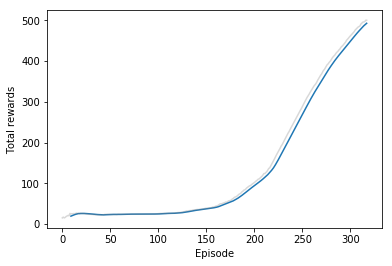

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

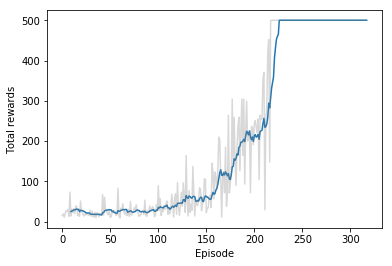

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

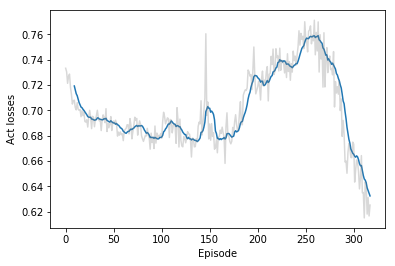

In [24]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

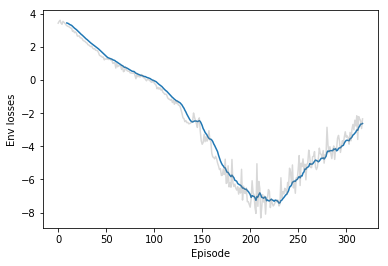

In [25]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

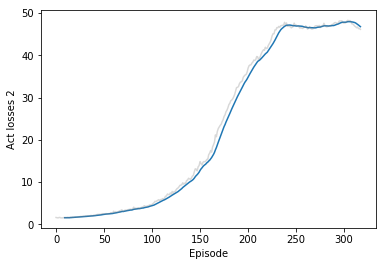

In [26]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
